# DATA2001 Asignment

In [1]:
from IPython.display import HTML
HTML('''
    <style> body {font-family: "Roboto Condensed Light", "Roboto Condensed";} h2 {padding: 10px 12px; background-color: #E64626; position: static; color: #ffffff; font-size: 40px;} .text_cell_render p { font-size: 15px; } .text_cell_render h1 { font-size: 30px; } h1 {padding: 10px 12px; background-color: #E64626; color: #ffffff; font-size: 40px;} .text_cell_render h3 { padding: 10px 12px; background-color: #0148A4; position: static; color: #ffffff; font-size: 20px;} h4:before{ 
    content: "@"; font-family:"Wingdings"; font-style:regular; margin-right: 4px;} .text_cell_render h4 {padding: 8px; font-family: "Roboto Condensed Light"; position: static; font-style: italic; background-color: #FFB800; color: #ffffff; font-size: 18px; text-align: center; border-radius: 5px;}input[type=submit] {background-color: #E64626; border: solid; border-color: #734036; color: white; padding: 8px 16px; text-decoration: none; margin: 4px 2px; cursor: pointer; border-radius: 20px;}</style>
''')

## TASK 1: Importing the Data

In [2]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon
from geoalchemy2 import Geometry, WKTElement
import matplotlib.pyplot as plt
import numpy as np

In [3]:
businesses = gpd.read_file("Businesses.csv")
stops = pd.read_csv('stops.txt', sep=',')
polls = gpd.read_file("PollingPlaces2019.csv")
#schools = gpd.read_file("catchments/catchments_future.shp") #add more here later
population = pd.read_csv("Population.csv") #has no geometric attributes
#income = gpd.read_file("Income.csv")

In [4]:
from sqlalchemy import create_engine
import psycopg2
import psycopg2.extras
import json

credentials = "Credentials.json"

In [5]:
def pgconnect(credential_filepath, db_schema="public"):
    with open(credential_filepath) as f:
        db_conn_dict = json.load(f)
        host       = db_conn_dict['host']
        db_user    = db_conn_dict['user']
        db_pw      = db_conn_dict['password']
        default_db = db_conn_dict['user']
        port       = db_conn_dict['port']
        try:
            db = create_engine(f'postgresql+psycopg2://{db_user}:{db_pw}@{host}:{port}/{default_db}', echo=False)
            conn = db.connect()
            print('Connected successfully.')
        except Exception as e:
            print("Unable to connect to the database.")
            print(e)
            db, conn = None, None
        return db,conn

In [6]:
def query(conn, sqlcmd, args=None, df=True):
    result = pd.DataFrame() if df else None
    try:
        if df:
            result = pd.read_sql_query(sqlcmd, conn, params=args)
        else:
            result = conn.execute(sqlcmd, args).fetchall()
            result = result[0] if len(result) == 1 else result
    except Exception as e:
        print("Error encountered: ", e, sep='\n')
    return result

In [7]:
db, conn = pgconnect(credentials)

Connected successfully.


In [8]:
query(conn, "select PostGIS_Version()")

,postgis_version
0,3.3 USE_GEOS=1 USE_PROJ=1 USE_STATS=1


In [9]:
##ADD CREATE SCHEMA IF NOT EXISTS AND SET SEARCH PATH, THEN TABLES ADDED AT END OF WHERE EACH OF THEM ARE CLEANED.

### Cleaning and Importing STOPS data

#### Converting longitude and latitude to spatuial object

Adding geometry column with coordinates taken from longitude and latitude an then dropping these columns as they are no longer needed.

In [10]:
stops['geom'] = gpd.points_from_xy(stops.stop_lon, stops.stop_lat)  # creating the geometry column
stops = stops.drop(columns=['stop_lat', 'stop_lon'])  # removing the old latitude/longitude fields

The longitude and latitude should be converted into into a well known text format such as the Spatial Reference Identifier (SRID) - in this case 4326, to represent the WGS84 world geodetic coordinate system. 

In [11]:
srid = 4326
stops['geom'] = stops['geom'].apply(lambda x: WKTElement(x.wkt, srid=srid))

In [12]:
stops['geom']

0          POINT (151.20666465471 -33.8822064874687)
1          POINT (151.20699145565 -33.8820421431408)
2         POINT (151.206292455081 -33.8840842535493)
3         POINT (151.198866071817 -33.8916900512711)
4         POINT (151.198881722942 -33.8933293130144)
                             ...                    
114713     POINT (151.07879697831 -33.8220164586429)
114714    POINT (151.116926480557 -33.8406690716775)
114715    POINT (151.116898892402 -33.8407691073139)
114716    POINT (151.010576673346 -33.8139042429414)
114717    POINT (151.010481768913 -33.8139523874985)
Name: geom, Length: 114718, dtype: object

#### Dealing with data quality issues

**Possible data quality issues include:**
 - missing items
 - missing value; search for empty strings and remove 
 - default value
 - incorrect values
 - inconsistent values

*In this dataset the following data quality issues need fixing:* 
 1. Default Value
 2. Removing unnessasry columns
 3. Removing duplicate columns

1. Checking for default values

In [13]:
stops.isna().any()

stop_id                False
stop_code               True
stop_name              False
location_type           True
parent_station          True
wheelchair_boarding    False
platform_code           True
geom                   False
dtype: bool

2. The formula for calculating the Z score for the stops in a particular SA2 region will require the following columns: stop_id and geom, as we have chosen to calculate the amount of public transport stops of any type for an sa2 region per sqkm. Thus only two columns need cleaning and the others can be removed.

In [14]:
stops_clean = stops.drop(['stop_code', 'stop_name', 'location_type','parent_station','wheelchair_boarding','platform_code' ], axis=1, inplace=True)

3. Removing duplicate columns

In [15]:
stops.drop_duplicates(inplace=True)

#### Importing Data to PostgreSQL

In [16]:
conn.execute("""
DROP TABLE IF EXISTS stops;
CREATE TABLE stops (
    stop_id VARCHAR(100), 
    geom GEOMETRY(POINT,4326)
);"""
)

In [17]:
stops.to_sql('stops', conn, if_exists='append', index=False, dtype={'geom': Geometry('POINT', srid)})
query(conn, "select * from stops")

,stop_id,geom
0,200039,0101000020E6100000FFA631FF9CE66240A1FF6524ECF0...
1,200054,0101000020E61000002F928BAC9FE66240E33DC7C1E6F0...
2,200060,0101000020E6100000817FA2F299E662408FF33DAC29F1...
3,201510,0101000020E61000009E57611C5DE6624060304CE622F2...
4,201646,0101000020E6100000DBF9333D5DE662403DFA6B9D58F2...
...,...,...
114713,212753,0101000020E6100000AF9B3D8185E262408F52D7D537E9...
114714,2137185,0101000020E6100000EB409ADCBDE3624089CE4C0B9BEB...
114715,2137186,0101000020E6100000C4F9BEA2BDE362403EB375529EEB...
114716,21501,0101000020E6100000E443E4A456E0624025C1A4032EE8...


In [18]:
# why did the number of rows double?! and is this the right way of loading tables into postgres, where do i add
# schema, here or in pgadmin??

### Cleaning POLLS GEOdataframe (has longitude and latitude). 

First the longitude and latitude should be converted into into a well known text format such as the Spatial Reference Identifier (SRID) - in this case 4326, to represent the WGS84 world geodetic coordinate system. 

Then possible data quality issues should be dealt with...

**Possible data quality issues include:**
 - missing items
 - missing value; search for empty strings and remove 
 - default value
 - incorrect values
 - inconsistent values

**In this dataset the following data quality issues need fixing:* 
 1. Duplicate rows
 2. Default Value
 3. Missing values (empty strings in certain in essential columns need to be detected.)

#### Dealing with data quality issues

**1. Removing any duplicate rows**

In [19]:
polls.drop_duplicates(inplace=True)

**2. Default Values: Checking whether there is any null values in each of the columns**

In [20]:
polls.isnull().any()

FID                            False
state                          False
division_id                    False
division_name                  False
polling_place_id               False
polling_place_type_id          False
polling_place_name             False
premises_name                  False
premises_address_1             False
premises_address_2             False
premises_address_3             False
premises_suburb                False
premises_state_abbreviation    False
premises_post_code             False
latitude                       False
longitude                      False
the_geom                       False
geometry                        True
dtype: bool

**3. Missing values: removing any columns with missing values in the 'the_geom' column**

In [21]:
for x in polls.index:
    if polls.loc[x, "the_geom"] == '':
        polls.drop(x, inplace = True)     

#### Converting longitude and latitude to spatuial object

Adding geometry column with coordinates taken from longitude and latitude an then dropping these columns as they are no longer needed.

In [22]:
polls['geom'] = gpd.points_from_xy(polls.longitude, polls.latitude)  # creating the geometry column
polls = polls.drop(columns=['latitude', 'longitude'])  # removing the old latitude/longitude fields

The longitude and latitude should be converted into into a well known text format such as the Spatial Reference Identifier (SRID) - in this case 4326, to represent the WGS84 world geodetic coordinate system. 

In [23]:
srid = 4326
polls['geom'] = polls['geom'].apply(lambda x: WKTElement(x.wkt, srid=srid))


Removing all uneeded columns for Z scores

In [24]:
polls = polls[['polling_place_name','geom']]

#### Importing to PostgreSQL

In [25]:
conn.execute("""
DROP TABLE IF EXISTS polls;
CREATE TABLE polls (
    polling_place_name VARCHAR(100), 
    geom GEOMETRY(POINT,4326)
);"""
)       

In [26]:
polls.to_sql('polls', conn, if_exists='append', index=False, dtype={'geom': Geometry('POINT', srid)})
query(conn, "select * from polls")

,polling_place_name,geom
0,Oatley,0101000020E61000003BDF4F8D97E26240832F4CA60AFE...
1,Dharruk,0101000020E6100000A01A2FDD24DA624048E17A14AEDF...
2,Allawah,0101000020E6100000A7EC4F3DADE36240EA48E47107FD...
3,Allawah South,0101000020E6100000643BDF4F8DE3624022FDF675E0FC...
4,Beverly Hills North (Banks),0101000020E61000006666666666E26240C6DCB5847CF8...
...,...,...
2785,Warilla North,0101000020E6100000D8B628B341DB62401288D7F50B46...
2786,Warilla South,0101000020E6100000FA7E6ABC74DB62409C33A2B43748...
2787,Warilla WHITLAM PPVC,0101000020E6100000BD32141C83DB624011F28B5C8146...
2788,Welby,0101000020E610000021B0726891CD6240386744696F38...


### Cleaning SA2 Regions

In [27]:
sa2 = gpd.read_file("SA2_regions/SA2_2021_AUST_GDA2020.shp")

In [28]:
if (sa2['GCC_NAME21'] == 'The Greater Sydney Region').any():
    print('omg')

#### Dealing with data quality issues

1. Default : the 'geometry' and 'SA2_CODE21' columns are crucial so if there are null values in eithert than the entire column should be deleted. 

In [29]:
sa2.isna().any()

SA2_CODE21    False
SA2_NAME21    False
CHG_FLAG21    False
CHG_LBL21     False
SA3_CODE21    False
SA3_NAME21    False
SA4_CODE21    False
SA4_NAME21    False
GCC_CODE21    False
GCC_NAME21    False
STE_CODE21    False
STE_NAME21    False
AUS_CODE21    False
AUS_NAME21    False
AREASQKM21     True
LOCI_URI21    False
geometry       True
dtype: bool

Identified that there are missing values in in the geomtry row that need removing.

In [30]:
sa2 = sa2.dropna(subset=['geometry'])

In [31]:
sa2.isna().any()

SA2_CODE21    False
SA2_NAME21    False
CHG_FLAG21    False
CHG_LBL21     False
SA3_CODE21    False
SA3_NAME21    False
SA4_CODE21    False
SA4_NAME21    False
GCC_CODE21    False
GCC_NAME21    False
STE_CODE21    False
STE_NAME21    False
AUS_CODE21    False
AUS_NAME21    False
AREASQKM21    False
LOCI_URI21    False
geometry      False
dtype: bool

2. Removing duplicate rows

In [32]:
sa2.drop_duplicates(inplace=True)

#### Tranforming geomtric data

First, ensure polygons in our dataset are multigons:

In [33]:
def create_wkt_element(geom, srid):
    if geom.geom_type == 'Polygon':
        geom = MultiPolygon([geom])
    return WKTElement(geom.wkt, srid)

In [34]:
sa2og = sa2.copy()  # creating a copy of the original for later
sa2['geom'] = sa2['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))  # applying the function
sa2 = sa2.drop(columns="geometry")  # deleting the old copy

We only need geometry column and the sa2 code column for Z score calculations so all others can be dropped for simplicity:

In [35]:
sa2 = sa2[['SA2_CODE21','SA2_NAME21','GCC_NAME21','geom']]

Renaming columns:

In [36]:
sa2 = sa2.rename({'SA2_CODE21': 'sa2code', 'SA2_NAME21' : 'sa2name','GCC_NAME21' : 'greatercapital' }, axis=1)  

#### Importing Data in PostgreSQL

In [37]:
conn.execute("""
DROP TABLE IF EXISTS sa2;
CREATE TABLE sa2 (
    sa2code NUMERIC, 
    sa2name VARCHAR(100),
    greatercapital VARCHAR(100),
    geom GEOMETRY(MULTIPOLYGON,4326)
);"""
)

In [38]:
sa2.to_sql("sa2", conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})
query(conn, "select * from sa2")

,sa2code,sa2name,greatercapital,geom
0,101021007.0,Braidwood,Rest of NSW,0106000020E6100000010000000103000000010000005D...
1,101021008.0,Karabar,Rest of NSW,0106000020E6100000010000000103000000010000002C...
2,101021610.0,Googong,Rest of NSW,0106000020E6100000010000000103000000010000006D...
3,101021611.0,Queanbeyan Surrounds,Rest of NSW,0106000020E61000000100000001030000000200000041...
4,101031013.0,Bombala,Rest of NSW,0106000020E61000000100000001030000000100000031...
...,...,...,...,...
2449,801111141.0,Namadgi,Australian Capital Territory,0106000020E6100000010000000103000000010000004B...
2450,901011001.0,Christmas Island,Other Territories,0106000020E61000000100000001030000000100000094...
2451,901021002.0,Cocos (Keeling) Islands,Other Territories,0106000020E610000038000000010300000001000000CF...
2452,901031003.0,Jervis Bay,Other Territories,0106000020E61000000300000001030000000100000016...


### Cleaning and Importing Population Data

For the population we need two datasets for our z scores, one for the entire population and one for young people (0-19 year olds)

In [39]:
youngpeople = population[['sa2_code', 'sa2_name', '0-4_people','5-9_people', '10-14_people','15-19_people']]

#### Cleaning youngpeople and importing into PostgreSQL

In [40]:
youngpeople.isnull().any()

sa2_code        False
sa2_name        False
0-4_people      False
5-9_people      False
10-14_people    False
15-19_people    False
dtype: bool

In [41]:
youngpeople.drop_duplicates(inplace=True)

/var/folders/2w/069ckckj585c6q8nbb3881km0000gn/T/ipykernel_46196/2472364614.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  youngpeople.drop_duplicates(inplace=True)


In [42]:
results = youngpeople.dtypes
print(results)

sa2_code         int64
sa2_name        object
0-4_people       int64
5-9_people       int64
10-14_people     int64
15-19_people     int64
dtype: object


In [43]:
# Define the columns to sum
columns_to_sum = ['0-4_people', '5-9_people', '10-14_people', '15-19_people']

# Calculate the sum for the selected columns along the rows axis
youngpeople['young_people'] = youngpeople[columns_to_sum].sum(axis=1)

youngpeople = youngpeople[['sa2_code','sa2_name','young_people']]

/var/folders/2w/069ckckj585c6q8nbb3881km0000gn/T/ipykernel_46196/694902732.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  youngpeople['young_people'] = youngpeople[columns_to_sum].sum(axis=1)


since will eventually need to divide by the number of young people we cannot have any zero values, these are outliers regardless.

In [44]:
youngpeople = youngpeople[youngpeople['young_people'] != 0]

importing young people to postgresql

In [45]:
conn.execute("""
DROP TABLE IF EXISTS population;
CREATE TABLE population (
    sa2_code NUMERIC, 
    sa2_name VARCHAR(100),
    young_people NUMERIC
);"""
)

In [46]:
youngpeople.to_sql('youngpeople', conn, if_exists='append', index=False, dtype={'geom': Geometry('POINT', srid)})
query(conn, "select * from youngpeople")

,sa2_code,sa2_name,young_people
0,102011028,Avoca Beach - Copacabana,2121
1,102011029,Box Head - MacMasters Beach,2471
2,102011030,Calga - Kulnura,961
3,102011031,Erina - Green Point,3205
4,102011032,Gosford - Springfield,4364
...,...,...,...
3337,128021537,Royal National Park,20
3338,128021538,Sutherland - Kirrawee,5078
3339,128021607,Engadine,5118
3340,128021608,Loftus - Yarrawarrah,2073


#### Cleaning population and importing into PostgreSQL

In [47]:
population_clean = population[['sa2_code','sa2_name','total_people']]

In [48]:
population_clean.isnull().any()

sa2_code        False
sa2_name        False
total_people    False
dtype: bool

In [49]:
population_clean.drop_duplicates(inplace=True)

/var/folders/2w/069ckckj585c6q8nbb3881km0000gn/T/ipykernel_46196/3705968791.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  population_clean.drop_duplicates(inplace=True)


In [50]:
conn.execute("""
DROP TABLE IF EXISTS population;
CREATE TABLE population (
    sa2_code NUMERIC, 
    sa2_name VARCHAR(100),
    total_people NUMERIC
);"""
)

In [51]:
population_clean.to_sql('population', conn, if_exists='append', index=False, dtype={'geom': Geometry('POINT', srid)})
query(conn, "select * from population")

,sa2_code,sa2_name,total_people
0,102011028.0,Avoca Beach - Copacabana,7530.0
1,102011029.0,Box Head - MacMasters Beach,11052.0
2,102011030.0,Calga - Kulnura,4748.0
3,102011031.0,Erina - Green Point,14803.0
4,102011032.0,Gosford - Springfield,21346.0
...,...,...,...
368,128021537.0,Royal National Park,45.0
369,128021538.0,Sutherland - Kirrawee,23369.0
370,128021607.0,Engadine,17379.0
371,128021608.0,Loftus - Yarrawarrah,7354.0


### Cleaning and Importing School Data

In [52]:
future_school = gpd.read_file("catchments/catchments_future.shp")
future_school
primary_school = gpd.read_file("catchments/catchments_primary.shp")
primary_school
secondary_school = gpd.read_file("catchments/catchments_secondary.shp")
#secondary_school

Removing unessasry columnns from each dataset

In [53]:
future_school = future_school[['USE_ID','USE_DESC','geometry']]
primary_school = primary_school[['USE_ID','USE_DESC','geometry']]
secondary_school = secondary_school[['USE_ID','USE_DESC','geometry']]

Removing duplicates

In [54]:
future_school.drop_duplicates(inplace=True)
primary_school.drop_duplicates(inplace=True)
secondary_school.drop_duplicates(inplace=True)

**Future Schools to SQL**

making the geomtric object consistently multigons and converting the coordintes to the well know universal form

In [55]:
srid = 4326
def create_wkt_element(geom, srid):
    if geom.geom_type == 'Polygon':
        geom = MultiPolygon([geom])
    return WKTElement(geom.wkt, srid)

future_school_copy = future_school.copy()  # creating a copy of the original for later
future_school['geom'] = future_school['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))  # applying the function
future_school = future_school.drop(columns="geometry")  # deleting the old copy

future_school = future_school.rename({'USE_ID' : 'use_id','USE_DESC' : 'school_name'}, axis =1)

conn.execute("""
 DROP TABLE IF EXISTS future_school;
 CREATE TABLE future_school (
     use_id NUMERIC, 
     school_name VARCHAR(100),
     geom GEOMETRY(MULTIPOLYGON,4326)
);"""
)


future_school.to_sql('future_school', conn, if_exists='append', index=False, dtype={'geom': Geometry('POINT', srid)})
query(conn, "select * from future_school")



,use_id,school_name,geom
0,8416.0,Ku-ring-gai HS,0106000020E61000000100000001030000000100000090...
1,8161.0,Randwick BHS,0106000020E6100000010000000103000000010000006F...
2,8539.0,SSC Blackwattle Bay,0106000020E610000001000000010300000001000000E3...
3,8286.0,Mt Annan HS,0106000020E61000000100000001030000000100000099...
4,4524.0,Hastings PS,0106000020E61000000100000001030000000100000060...
5,8554.0,HSC Westport,0106000020E610000001000000010300000001000000FE...
6,8400.0,St Ives HS,0106000020E61000000100000001030000000100000060...
7,8555.0,Rose Bay SC,0106000020E6100000010000000103000000010000000C...
8,8135.0,Parramatta HS,0106000020E6100000010000000103000000010000001F...
9,8556.0,Alexandria Park CS,0106000020E61000000100000001030000000100000028...


**Primary School to SQL**

In [56]:
def create_wkt_element(geom, srid):
    if geom.geom_type == 'Polygon':
        geom = MultiPolygon([geom])
    return WKTElement(geom.wkt, srid)

primary_school_copy = primary_school.copy()  # creating a copy of the original for later
primary_school['geom'] = primary_school['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))  # applying the function
primary_school = primary_school.drop(columns="geometry")  # deleting the old copy

primary_school = primary_school.rename({'USE_ID' : 'use_id','USE_DESC' : 'school_name'}, axis =1)

conn.execute("""
 DROP TABLE IF EXISTS primary_school;
 CREATE TABLE primary_school (
     use_id NUMERIC, 
     school_name VARCHAR(100),
     geom GEOMETRY(MULTIPOLYGON,4326)
);"""
)


primary_school.to_sql('primary_school', conn, if_exists='append', index=False, dtype={'geom': Geometry('POINT', srid)})
query(conn, "select * from primary_school")



,use_id,school_name,geom
0,2838.0,Parklea PS,0106000020E61000000100000001030000000100000078...
1,2404.0,Lindfield EPS,0106000020E610000001000000010300000001000000BE...
2,4393.0,Carlingford WPS,0106000020E61000000100000001030000000100000065...
3,4481.0,St Andrews PS,0106000020E61000000100000001030000000100000040...
4,4615.0,Caddies Ck PS,0106000020E61000000100000001030000000100000056...
...,...,...,...
1657,2409.0,Lismore SPS,0106000020E610000001000000010300000001000000C9...
1658,4383.0,E A Southee PS,0106000020E610000001000000010300000001000000B9...
1659,3275.0,Tumbarumba PS,0106000020E610000001000000010300000001000000C0...
1660,2239.0,Jindera PS,0106000020E610000001000000010300000001000000F6...


**High School to SQL**

In [57]:
secondary_school_copy = secondary_school.copy()  # creating a copy of the original for later
secondary_school['geom'] = secondary_school['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))  # applying the function
secondary_school = secondary_school.drop(columns="geometry")  # deleting the old copy

secondary_school = secondary_school.rename({'USE_ID' : 'use_id','USE_DESC' : 'school_name'}, axis =1)

conn.execute("""
 DROP TABLE IF EXISTS secondary_school;
 CREATE TABLE secondary_school (
     use_id NUMERIC, 
     school_name VARCHAR(100),
     geom GEOMETRY(MULTIPOLYGON,4326)
);"""
)

secondary_school.to_sql('secondary_school', conn, if_exists='append', index=False, dtype={'geom': Geometry('POINT', srid)})
query(conn, "select * from secondary_school")




,use_id,school_name,geom
0,8503.0,Billabong HS,0106000020E6100000010000000103000000010000006D...
1,8266.0,James Fallon HS,0106000020E61000000100000001030000000100000071...
2,8559.0,Jamison HS,0106000020E6100000010000000103000000020000002F...
3,8502.0,Tomaree HS,0106000020E6100000010000000103000000010000003B...
4,8505.0,Murray HS,0106000020E6100000010000000103000000010000003F...
...,...,...,...
431,8213.0,Birrong BHS,0106000020E61000000100000001030000000100000040...
432,8108.0,Cessnock HS,0106000020E610000001000000010300000001000000AD...
433,3235.0,Tooleybuc CS,0106000020E6100000010000000103000000010000003E...
434,1115.0,Balranald CS,0106000020E6100000010000000103000000010000005B...


**Merging school tables**

In [58]:
all_schools = gpd.GeoDataFrame(pd.concat([future_school, primary_school, secondary_school], ignore_index = True))

**Cleaning merged schools table**

In [59]:
all_schools.isnull().any()

use_id         False
school_name    False
geom           False
dtype: bool

In [60]:
all_schools.drop_duplicates(inplace=True)

**Creating new SQL Table for all schools**

In [61]:
conn.execute("""
 DROP TABLE IF EXISTS all_schools;
 CREATE TABLE all_schools (
     use_id NUMERIC, 
     school_name VARCHAR(100),
     geom GEOMETRY(MULTIPOLYGON,4326)
);"""
)

all_schools.to_sql('all_schools', conn, if_exists='append', index=False, dtype={'geom': Geometry('POINT', srid)})
query(conn, "select * from all_schools")

,use_id,school_name,geom
0,8416.0,Ku-ring-gai HS,0106000020E61000000100000001030000000100000090...
1,8161.0,Randwick BHS,0106000020E6100000010000000103000000010000006F...
2,3918.0,Killara PS,0106000020E61000000100000001030000000100000042...
3,3396.0,Waterfall PS,0106000020E610000001000000010300000001000000E1...
4,2304.0,Kincumber PS,0106000020E61000000100000001030000000100000001...
...,...,...,...
2091,8593.0,Vincentia HS,0106000020E610000001000000010300000001000000E1...
2092,8213.0,Birrong BHS,0106000020E61000000100000001030000000100000040...
2093,8108.0,Cessnock HS,0106000020E610000001000000010300000001000000AD...
2094,1115.0,Balranald CS,0106000020E6100000010000000103000000010000005B...


**Creating Z scores for School table**

## Task 2: Creating SA2 scores

### Z score for Polls

GOAL: Find how many polling places there are per sqkm of each sa2 region.
1. Finding how many polling places there are in each sa2 region by grouping by SA2 regions?

In [62]:
sql = """
SELECT *
FROM sa2
WHERE greatercapital = 'Greater Sydney'
"""
query(conn, sql)

,sa2code,sa2name,greatercapital,geom
0,102011028.0,Avoca Beach - Copacabana,Greater Sydney,0106000020E6100000010000000103000000010000005E...
1,102011029.0,Box Head - MacMasters Beach,Greater Sydney,0106000020E61000000100000001030000000100000010...
2,102011030.0,Calga - Kulnura,Greater Sydney,0106000020E61000000200000001030000000100000085...
3,102011031.0,Erina - Green Point,Greater Sydney,0106000020E61000000100000001030000000100000041...
4,102011032.0,Gosford - Springfield,Greater Sydney,0106000020E6100000010000000103000000010000007E...
...,...,...,...,...
368,128011602.0,Caringbah,Greater Sydney,0106000020E610000001000000010300000001000000EF...
369,128011603.0,Caringbah South,Greater Sydney,0106000020E610000001000000010300000001000000E9...
370,128011604.0,Cronulla - Kurnell - Bundeena,Greater Sydney,0106000020E610000003000000010300000001000000C3...
371,128021608.0,Loftus - Yarrawarrah,Greater Sydney,0106000020E610000001000000010300000001000000A1...


finding how many polling places there for each sa2 region

In [208]:
sql = """
SELECT s.sa2name, s.sa2code, count(*) as polling_places
FROM sa2 s JOIN polls p ON (ST_CONTAINS(s.geom, p.geom))
WHERE greatercapital = 'Greater Sydney'
GROUP BY s.sa2name, s.sa2code
"""
query(conn, sql)

,sa2name,sa2code,polling_places
0,Acacia Gardens,116021562.0,1
1,Annandale (NSW),120021674.0,4
2,Arncliffe - Bardwell Valley,119041668.0,5
3,Artarmon,121011682.0,2
4,Ashcroft - Busby - Miller,127011504.0,4
...,...,...,...
348,Wyoming,102011043.0,5
349,Wyong,102021057.0,6
350,Yagoona - Birrong,119011361.0,3
351,Yarramundi - Londonderry,124041468.0,3


add a column for the region size in sqm and another column for how many polling places there are per sqkm (number of polling places/number of sqkm for each row.

In [209]:
sql = """
SELECT s.sa2name, s.sa2code, count(*) as polling_places, ST_Area(s.geom::geography)*1/1000000 AS total_area_km2, count(*)/(ST_Area(s.geom::geography)*1/1000000) AS polling_places_per_sqkm
FROM sa2 s JOIN polls p ON (ST_CONTAINS(s.geom, p.geom))
WHERE greatercapital = 'Greater Sydney'
GROUP BY s.geom, s.sa2name , s.sa2code
"""
query(conn, sql)

,sa2name,sa2code,polling_places,total_area_km2,polling_places_per_sqkm
0,Bexley - North,119041669.0,1,2.600401,0.384556
1,Blacktown - South,116011560.0,4,3.359551,1.190635
2,Glenwood,116021309.0,3,5.118636,0.586094
3,Macquarie Fields,123021706.0,4,9.022946,0.443314
4,Lawson - Hazelbrook - Linden,124011453.0,3,46.887211,0.063983
...,...,...,...,...,...
348,Eastwood,126021723.0,6,5.292188,1.133747
349,Cronulla - Kurnell - Bundeena,128011604.0,7,25.085295,0.279048
350,Casula,127031522.0,2,7.071984,0.282806
351,Edmondson Park,127031730.0,1,6.056298,0.165117


To calculate the Z score for each sa2 region I will calculate the mean and population standard deviation for the number of polling places per sqkm and create a Z score for each region based on this.

In [210]:
sa2_and_polls = pd.read_sql_query(sql, conn)
sa2_and_polls

,sa2name,sa2code,polling_places,total_area_km2,polling_places_per_sqkm
0,Bexley - North,119041669.0,1,2.600401,0.384556
1,Blacktown - South,116011560.0,4,3.359551,1.190635
2,Glenwood,116021309.0,3,5.118636,0.586094
3,Macquarie Fields,123021706.0,4,9.022946,0.443314
4,Lawson - Hazelbrook - Linden,124011453.0,3,46.887211,0.063983
...,...,...,...,...,...
348,Eastwood,126021723.0,6,5.292188,1.133747
349,Cronulla - Kurnell - Bundeena,128011604.0,7,25.085295,0.279048
350,Casula,127031522.0,2,7.071984,0.282806
351,Edmondson Park,127031730.0,1,6.056298,0.165117


In [211]:
mean = np.mean(sa2_and_polls['polling_places_per_sqkm'])
std = np.std(sa2_and_polls['polling_places_per_sqkm']) 
print(mean)
print(std)

1.0090544026754658
1.9180048945395745


Thus i will take the mean as 1.01 and std as 1.9

In [212]:
sql = """
SELECT s.sa2name, s.sa2code, count(*) as polling_places, ST_Area(s.geom::geography)*1/1000000 AS total_area_km2, count(*)/(ST_Area(s.geom::geography)*1/1000000) AS polling_places_per_sqkm, ((count(*)/(ST_Area(s.geom::geography)*1/1000000)  - 1.01)/1.9) AS zscore 
FROM sa2 s JOIN polls p ON (ST_CONTAINS(s.geom, p.geom))
WHERE greatercapital = 'Greater Sydney'
GROUP BY s.geom, s.sa2name, s.sa2code
"""
query(conn, sql)

,sa2name,sa2code,polling_places,total_area_km2,polling_places_per_sqkm,zscore
0,Bexley - North,119041669.0,1,2.600401,0.384556,-0.329181
1,Blacktown - South,116011560.0,4,3.359551,1.190635,0.095071
2,Glenwood,116021309.0,3,5.118636,0.586094,-0.223109
3,Macquarie Fields,123021706.0,4,9.022946,0.443314,-0.298256
4,Lawson - Hazelbrook - Linden,124011453.0,3,46.887211,0.063983,-0.497904
...,...,...,...,...,...,...
348,Eastwood,126021723.0,6,5.292188,1.133747,0.065130
349,Cronulla - Kurnell - Bundeena,128011604.0,7,25.085295,0.279048,-0.384712
350,Casula,127031522.0,2,7.071984,0.282806,-0.382734
351,Edmondson Park,127031730.0,1,6.056298,0.165117,-0.444675


In [213]:
polls_z = pd.read_sql_query(sql, conn)

In [214]:
polls_z = pd.read_sql_query(sql, conn)
polls_z = polls_z[['sa2code','zscore']]

conn.execute("""
DROP TABLE IF EXISTS polls_z;
CREATE TABLE polls_z (
    sa2code NUMERIC, 
    zscore NUMERIC
);"""
)

polls_z.to_sql('polls_z', conn, if_exists='append', index=False, dtype={'geom': Geometry('POINT', srid)})
query(conn, "select * from polls_z")

,sa2code,zscore
0,119041669.0,-0.329181
1,116011560.0,0.095071
2,116021309.0,-0.223109
3,123021706.0,-0.298256
4,124011453.0,-0.497904
...,...,...
348,126021723.0,0.065130
349,128011604.0,-0.384712
350,127031522.0,-0.382734
351,127031730.0,-0.444675


### Z score for Stops

In [68]:
sql = """
SELECT *
FROM stops
"""
query(conn, sql)

,stop_id,geom
0,200039,0101000020E6100000FFA631FF9CE66240A1FF6524ECF0...
1,200054,0101000020E61000002F928BAC9FE66240E33DC7C1E6F0...
2,200060,0101000020E6100000817FA2F299E662408FF33DAC29F1...
3,201510,0101000020E61000009E57611C5DE6624060304CE622F2...
4,201646,0101000020E6100000DBF9333D5DE662403DFA6B9D58F2...
...,...,...
114713,212753,0101000020E6100000AF9B3D8185E262408F52D7D537E9...
114714,2137185,0101000020E6100000EB409ADCBDE3624089CE4C0B9BEB...
114715,2137186,0101000020E6100000C4F9BEA2BDE362403EB375529EEB...
114716,21501,0101000020E6100000E443E4A456E0624025C1A4032EE8...


In [69]:
sql = """
SELECT s.sa2name, count(*) as number_stops
FROM sa2 s JOIN stops o ON (ST_CONTAINS(s.geom, o.geom))
WHERE greatercapital = 'Greater Sydney'
GROUP BY s.sa2name
"""
query(conn, sql)

,sa2name,number_stops
0,Acacia Gardens,39
1,Annandale (NSW),40
2,Arncliffe - Bardwell Valley,85
3,Artarmon,35
4,Ashcroft - Busby - Miller,217
...,...,...
367,Wyong,191
368,Yagoona - Birrong,221
369,Yarramundi - Londonderry,107
370,Yennora Industrial,13


In [196]:
sql = """
SELECT s.sa2name, s.sa2code, count(*) as number_stops, ST_Area(s.geom::geography)*1/1000000 AS total_area_km2, count(*)/(ST_Area(s.geom::geography)*1/1000000) AS stops_per_sqkm
FROM sa2 s JOIN stops o ON (ST_CONTAINS(s.geom, o.geom))
WHERE greatercapital = 'Greater Sydney'
GROUP BY s.geom, s.sa2name, sa2code 
"""
query(conn, sql)


,sa2name,sa2code,number_stops,total_area_km2,stops_per_sqkm
0,Bexley - North,119041669.0,116,2.600401,44.608501
1,Marsden Park - Shanes Park,116021629.0,88,25.040909,3.514249
2,Blacktown - South,116011560.0,82,3.359551,24.408025
3,Glenwood,116021309.0,127,5.118636,24.811296
4,Macquarie Fields,123021706.0,181,9.022946,20.059967
...,...,...,...,...,...
367,Cronulla - Kurnell - Bundeena,128011604.0,244,25.085295,9.726814
368,Casula,127031522.0,191,7.071984,27.007980
369,Edmondson Park,127031730.0,47,6.056298,7.760516
370,Fairfield - West,127021516.0,139,4.691202,29.629936


In [197]:
sa2_and_stops = pd.read_sql_query(sql, conn)
sa2_and_stops

,sa2name,sa2code,number_stops,total_area_km2,stops_per_sqkm
0,Bexley - North,119041669.0,116,2.600401,44.608501
1,Marsden Park - Shanes Park,116021629.0,88,25.040909,3.514249
2,Blacktown - South,116011560.0,82,3.359551,24.408025
3,Glenwood,116021309.0,127,5.118636,24.811296
4,Macquarie Fields,123021706.0,181,9.022946,20.059967
...,...,...,...,...,...
367,Cronulla - Kurnell - Bundeena,128011604.0,244,25.085295,9.726814
368,Casula,127031522.0,191,7.071984,27.007980
369,Edmondson Park,127031730.0,47,6.056298,7.760516
370,Fairfield - West,127021516.0,139,4.691202,29.629936


In [198]:
mean = np.mean(sa2_and_stops['stops_per_sqkm'])
std = np.std(sa2_and_stops['stops_per_sqkm']) 
print(mean)
print(std)

25.60129457953051
14.784718875217486


In [201]:
sql = """
SELECT s.sa2name, s.sa2code, count(*) as number_stops, ST_Area(s.geom::geography)*1/1000000 AS total_area_km2, count(*)/(ST_Area(s.geom::geography)*1/1000000) AS stops_per_sqkm, ((count(*)/(ST_Area(s.geom::geography)*1/1000000))-25.6)/14.8 AS zscore
FROM sa2 s JOIN stops o ON (ST_CONTAINS(s.geom, o.geom))
WHERE greatercapital = 'Greater Sydney'
GROUP BY s.geom, s.sa2name , s.sa2code
"""
query(conn, sql)

,sa2name,sa2code,number_stops,total_area_km2,stops_per_sqkm,zscore
0,Bexley - North,119041669.0,116,2.600401,44.608501,1.284358
1,Marsden Park - Shanes Park,116021629.0,88,25.040909,3.514249,-1.492280
2,Blacktown - South,116011560.0,82,3.359551,24.408025,-0.080539
3,Glenwood,116021309.0,127,5.118636,24.811296,-0.053291
4,Macquarie Fields,123021706.0,181,9.022946,20.059967,-0.374327
...,...,...,...,...,...,...
367,Cronulla - Kurnell - Bundeena,128011604.0,244,25.085295,9.726814,-1.072513
368,Casula,127031522.0,191,7.071984,27.007980,0.095134
369,Edmondson Park,127031730.0,47,6.056298,7.760516,-1.205371
370,Fairfield - West,127021516.0,139,4.691202,29.629936,0.272293


In [202]:
stops_z = pd.read_sql_query(sql, conn)

In [203]:
stops_z = pd.read_sql_query(sql, conn)
stops_z = stops_z[['sa2code','zscore']]

conn.execute("""
DROP TABLE IF EXISTS stops_z;
CREATE TABLE stops_z (
    sa2code NUMERIC, 
    zscore NUMERIC
);"""
)

stops_z.to_sql('stops_z', conn, if_exists='append', index=False, dtype={'geom': Geometry('POINT', srid)})
query(conn, "select * from stops_z")

,sa2code,zscore
0,119041669.0,1.284358
1,116021629.0,-1.492280
2,116011560.0,-0.080539
3,116021309.0,-0.053291
4,123021706.0,-0.374327
...,...,...
367,128011604.0,-1.072513
368,127031522.0,0.095134
369,127031730.0,-1.205371
370,127021516.0,0.272293


### Z score for Schools

In [74]:
sql = """
SELECT s.sa2code, s.sa2name, COUNT(*) as number_of_schools
FROM sa2 s JOIN all_schools a ON (ST_Intersects(s.geom, a.geom))
WHERE s.greatercapital = 'Greater Sydney'
GROUP BY s.sa2code, s.sa2name

"""
query(conn, sql)


,sa2code,sa2name,number_of_schools
0,102011028.0,Avoca Beach - Copacabana,6
1,102011029.0,Box Head - MacMasters Beach,7
2,102011030.0,Calga - Kulnura,26
3,102011031.0,Erina - Green Point,17
4,102011032.0,Gosford - Springfield,14
...,...,...,...
368,128021537.0,Royal National Park,17
369,128021538.0,Sutherland - Kirrawee,17
370,128021607.0,Engadine,11
371,128021608.0,Loftus - Yarrawarrah,9


In [75]:
sa2_and_schools = pd.read_sql_query(sql, conn)
sa2_and_schools

,sa2code,sa2name,number_of_schools
0,102011028.0,Avoca Beach - Copacabana,6
1,102011029.0,Box Head - MacMasters Beach,7
2,102011030.0,Calga - Kulnura,26
3,102011031.0,Erina - Green Point,17
4,102011032.0,Gosford - Springfield,14
...,...,...,...
368,128021537.0,Royal National Park,17
369,128021538.0,Sutherland - Kirrawee,17
370,128021607.0,Engadine,11
371,128021608.0,Loftus - Yarrawarrah,9


In [76]:
conn.execute("""
DROP TABLE IF EXISTS sa2_and_schools;
CREATE TABLE sa2_and_schools (
    sa2code NUMERIC, 
    sa2name VARCHAR(100),
    number_of_schools NUMERIC
);"""
)

In [77]:
sa2_and_schools.to_sql('sa2_and_schools', conn, if_exists='append', index=False, dtype={'geom': Geometry('POINT', srid)})
query(conn, "select * from sa2_and_schools")


,sa2code,sa2name,number_of_schools
0,102011028.0,Avoca Beach - Copacabana,6.0
1,102011029.0,Box Head - MacMasters Beach,7.0
2,102011030.0,Calga - Kulnura,26.0
3,102011031.0,Erina - Green Point,17.0
4,102011032.0,Gosford - Springfield,14.0
...,...,...,...
368,128021537.0,Royal National Park,17.0
369,128021538.0,Sutherland - Kirrawee,17.0
370,128021607.0,Engadine,11.0
371,128021608.0,Loftus - Yarrawarrah,9.0


In [78]:
sql = """
SELECT *
FROM sa2_and_schools

"""
query(conn, sql)

,sa2code,sa2name,number_of_schools
0,102011028.0,Avoca Beach - Copacabana,6.0
1,102011029.0,Box Head - MacMasters Beach,7.0
2,102011030.0,Calga - Kulnura,26.0
3,102011031.0,Erina - Green Point,17.0
4,102011032.0,Gosford - Springfield,14.0
...,...,...,...
368,128021537.0,Royal National Park,17.0
369,128021538.0,Sutherland - Kirrawee,17.0
370,128021607.0,Engadine,11.0
371,128021608.0,Loftus - Yarrawarrah,9.0


In [79]:
sql = """
SELECT s.sa2code, s.sa2name, s.number_of_schools, y.young_people, (number_of_schools/young_people)*1000 AS schools_per_thousand 
FROM sa2_and_schools s JOIN youngpeople y ON (s.sa2code =  y.sa2_code)
GROUP BY s.sa2code, s.sa2name, s.number_of_schools, y.young_people
HAVING y.young_people >= 100
ORDER BY s.sa2name
"""
query(conn, sql)

,sa2code,sa2name,number_of_schools,young_people,schools_per_thousand
0,116021562.0,Acacia Gardens,5.0,1062,4.708098
1,120021674.0,Annandale (NSW),9.0,1947,4.622496
2,119041668.0,Arncliffe - Bardwell Valley,14.0,3501,3.998857
3,121011682.0,Artarmon,9.0,2290,3.930131
4,127011504.0,Ashcroft - Busby - Miller,16.0,5850,2.735043
...,...,...,...,...,...
354,102011043.0,Wyoming,11.0,2841,3.871876
355,102021057.0,Wyong,8.0,2301,3.476749
356,119011361.0,Yagoona - Birrong,15.0,6436,2.330640
357,124041468.0,Yarramundi - Londonderry,18.0,1730,10.404624


In [80]:
schools = pd.read_sql_query(sql, conn)
schools

,sa2code,sa2name,number_of_schools,young_people,schools_per_thousand
0,116021562.0,Acacia Gardens,5.0,1062,4.708098
1,120021674.0,Annandale (NSW),9.0,1947,4.622496
2,119041668.0,Arncliffe - Bardwell Valley,14.0,3501,3.998857
3,121011682.0,Artarmon,9.0,2290,3.930131
4,127011504.0,Ashcroft - Busby - Miller,16.0,5850,2.735043
...,...,...,...,...,...
354,102011043.0,Wyoming,11.0,2841,3.871876
355,102021057.0,Wyong,8.0,2301,3.476749
356,119011361.0,Yagoona - Birrong,15.0,6436,2.330640
357,124041468.0,Yarramundi - Londonderry,18.0,1730,10.404624


In [81]:
mean = np.mean(schools['schools_per_thousand'])
std = np.std(schools['schools_per_thousand']) 
print(mean)
print(std)

4.144324095246407
3.099225634750314


In [180]:
sql = """
SELECT s.sa2code, s.sa2name, s.number_of_schools, y.young_people, (number_of_schools/young_people)*1000 AS schools_per_thousand, ((number_of_schools/young_people)*1000 - 4.14)/3.1 as Zscore
FROM sa2_and_schools s JOIN youngpeople y ON (s.sa2code =  y.sa2_code)
GROUP BY s.sa2code, s.sa2name, s.number_of_schools, y.young_people
HAVING y.young_people >= 100
ORDER BY s.sa2name
"""
query(conn, sql)

,sa2code,sa2name,number_of_schools,young_people,schools_per_thousand,zscore
0,116021562.0,Acacia Gardens,5.0,1062,4.708098,0.183257
1,120021674.0,Annandale (NSW),9.0,1947,4.622496,0.155644
2,119041668.0,Arncliffe - Bardwell Valley,14.0,3501,3.998857,-0.045530
3,121011682.0,Artarmon,9.0,2290,3.930131,-0.067700
4,127011504.0,Ashcroft - Busby - Miller,16.0,5850,2.735043,-0.453212
...,...,...,...,...,...,...
354,102011043.0,Wyoming,11.0,2841,3.871876,-0.086492
355,102021057.0,Wyong,8.0,2301,3.476749,-0.213952
356,119011361.0,Yagoona - Birrong,15.0,6436,2.330640,-0.583664
357,124041468.0,Yarramundi - Londonderry,18.0,1730,10.404624,2.020847


In [181]:
schools_z = pd.read_sql_query(sql, conn)

In [190]:
school_z = pd.read_sql_query(sql, conn)
school_z = school_z[['sa2code','zscore']]

conn.execute("""
DROP TABLE IF EXISTS school_z;
CREATE TABLE school_z (
    sa2code NUMERIC, 
    zscore NUMERIC
);"""
)

school_z.to_sql('school_z', conn, if_exists='append', index=False, dtype={'geom': Geometry('POINT', srid)})
query(conn, "select * from school_z")

,sa2code,zscore
0,116021562.0,0.183257
1,120021674.0,0.155644
2,119041668.0,-0.045530
3,121011682.0,-0.067700
4,127011504.0,-0.453212
...,...,...
354,102011043.0,-0.086492
355,102021057.0,-0.213952
356,119011361.0,-0.583664
357,124041468.0,2.020847


### Z Scores for Health Dataset 

In [129]:
df = pd.read_csv("new_health2001_file.csv")
health = 'businesses_health'

df.to_sql('df', conn, if_exists='append', index=False, dtype={'geom': Geometry('POINT', srid)})
query(conn, "select * from health")

,Unnamed: 0,industry_name,sa2_code,sa2_name,total_businesses
0,10288,Health Care and Social Assistance,101021007,Braidwood,13
1,10289,Health Care and Social Assistance,101021008,Karabar,12
2,10290,Health Care and Social Assistance,101021009,Queanbeyan,60
3,10291,Health Care and Social Assistance,101021010,Queanbeyan - East,16
4,10292,Health Care and Social Assistance,101021012,Queanbeyan West - Jerrabomberra,31
...,...,...,...,...,...
638,10926,Health Care and Social Assistance,128021538,Sutherland - Kirrawee,178
639,10927,Health Care and Social Assistance,128021607,Engadine,77
640,10928,Health Care and Social Assistance,128021608,Loftus - Yarrawarrah,22
641,10929,Health Care and Social Assistance,128021609,Woronora Heights,15


In [109]:
sql = """
SELECT *
FROM population
ORDER BY sa2_name

"""
query(conn, sql)

,sa2_code,sa2_name,total_people
0,116021562.0,Acacia Gardens,3681.0
1,120021674.0,Annandale (NSW),9516.0
2,119041668.0,Arncliffe - Bardwell Valley,16651.0
3,121011682.0,Artarmon,9469.0
4,127011504.0,Ashcroft - Busby - Miller,18088.0
...,...,...,...
368,102021057.0,Wyong,9193.0
369,119011361.0,Yagoona - Birrong,22580.0
370,124041468.0,Yarramundi - Londonderry,7564.0
371,125031487.0,Yennora Industrial,13.0


In [85]:
population_clean

,sa2_code,sa2_name,total_people
0,102011028,Avoca Beach - Copacabana,7530
1,102011029,Box Head - MacMasters Beach,11052
2,102011030,Calga - Kulnura,4748
3,102011031,Erina - Green Point,14803
4,102011032,Gosford - Springfield,21346
...,...,...,...
368,128021537,Royal National Park,45
369,128021538,Sutherland - Kirrawee,23369
370,128021607,Engadine,17379
371,128021608,Loftus - Yarrawarrah,7354


In [86]:
sql = """
SELECT s.sa2code, s.sa2name, h.total_businesses
FROM health h JOIN sa2 s ON (h.sa2_code = s.sa2code)
WHERE s.greatercapital = 'Greater Sydney'
GROUP BY s.sa2code, s.sa2name, h.total_businesses
ORDER BY s.sa2name

"""
query(conn, sql)

,sa2code,sa2name,total_businesses
0,116021562.0,Acacia Gardens,22
1,120021674.0,Annandale (NSW),131
2,119041668.0,Arncliffe - Bardwell Valley,62
3,121011682.0,Artarmon,90
4,127011504.0,Ashcroft - Busby - Miller,55
...,...,...,...
368,102021057.0,Wyong,34
369,119011361.0,Yagoona - Birrong,126
370,124041468.0,Yarramundi - Londonderry,13
371,125031487.0,Yennora Industrial,0


In [87]:
health_clean = pd.read_sql_query(sql, conn)
health_clean

,sa2code,sa2name,total_businesses
0,116021562.0,Acacia Gardens,22
1,120021674.0,Annandale (NSW),131
2,119041668.0,Arncliffe - Bardwell Valley,62
3,121011682.0,Artarmon,90
4,127011504.0,Ashcroft - Busby - Miller,55
...,...,...,...
368,102021057.0,Wyong,34
369,119011361.0,Yagoona - Birrong,126
370,124041468.0,Yarramundi - Londonderry,13
371,125031487.0,Yennora Industrial,0


In [88]:
conn.execute("""
DROP TABLE IF EXISTS health_clean;
CREATE TABLE health_clean (
    sa2code NUMERIC, 
    sa2name VARCHAR(100),
    total_businesses NUMERIC
);"""
)

In [89]:
health_clean.to_sql('health_clean', conn, if_exists='append', index=False, dtype={'geom': Geometry('POINT', srid)})
query(conn, "select * from health_clean")


,sa2code,sa2name,total_businesses
0,116021562.0,Acacia Gardens,22.0
1,120021674.0,Annandale (NSW),131.0
2,119041668.0,Arncliffe - Bardwell Valley,62.0
3,121011682.0,Artarmon,90.0
4,127011504.0,Ashcroft - Busby - Miller,55.0
...,...,...,...
368,102021057.0,Wyong,34.0
369,119011361.0,Yagoona - Birrong,126.0
370,124041468.0,Yarramundi - Londonderry,13.0
371,125031487.0,Yennora Industrial,0.0


In [116]:
sql = """
SELECT h.sa2code, h.sa2name, h.total_businesses, p.total_people, ( h.total_businesses/p.total_people)*1000 AS health_per_thousand
FROM health_clean h JOIN population p ON (h.sa2code = p.sa2_code)
GROUP BY h.sa2code, h.sa2name, h.total_businesses, p.total_people
HAVING p.total_people >=100
ORDER BY h.sa2name

"""
query(conn, sql)

,sa2code,sa2name,total_businesses,total_people,health_per_thousand
0,116021562.0,Acacia Gardens,22.0,3681.0,5.976637
1,120021674.0,Annandale (NSW),131.0,9516.0,13.766288
2,119041668.0,Arncliffe - Bardwell Valley,62.0,16651.0,3.723500
3,121011682.0,Artarmon,90.0,9469.0,9.504700
4,127011504.0,Ashcroft - Busby - Miller,55.0,18088.0,3.040690
...,...,...,...,...,...
355,102011043.0,Wyoming,63.0,11457.0,5.498822
356,102021057.0,Wyong,34.0,9193.0,3.698466
357,119011361.0,Yagoona - Birrong,126.0,22580.0,5.580159
358,124041468.0,Yarramundi - Londonderry,13.0,7564.0,1.718667


In [118]:
health_final = pd.read_sql_query(sql, conn)

In [175]:
mean = np.mean(health_final['health_per_thousand'])
std = np.std(health_final['health_per_thousand']) 
print(mean)
print(std)

8.081093825953344
8.136867524923316


In [176]:
sql = """
SELECT h.sa2code, h.sa2name, h.total_businesses, p.total_people,  (h.total_businesses/p.total_people)*1000 AS health_per_thousand, ((h.total_businesses/p.total_people)*1000 - 8.08)/8.14 AS Zscore 
FROM health_clean h JOIN population p ON (h.sa2code = p.sa2_code)
GROUP BY h.sa2code, h.sa2name, h.total_businesses, p.total_people
HAVING p.total_people >=100
ORDER BY h.sa2name

"""
query(conn, sql)

,sa2code,sa2name,total_businesses,total_people,health_per_thousand,zscore
0,116021562.0,Acacia Gardens,22.0,3681.0,5.976637,-0.258398
1,120021674.0,Annandale (NSW),131.0,9516.0,13.766288,0.698561
2,119041668.0,Arncliffe - Bardwell Valley,62.0,16651.0,3.723500,-0.535197
3,121011682.0,Artarmon,90.0,9469.0,9.504700,0.175025
4,127011504.0,Ashcroft - Busby - Miller,55.0,18088.0,3.040690,-0.619080
...,...,...,...,...,...,...
355,102011043.0,Wyoming,63.0,11457.0,5.498822,-0.317098
356,102021057.0,Wyong,34.0,9193.0,3.698466,-0.538272
357,119011361.0,Yagoona - Birrong,126.0,22580.0,5.580159,-0.307106
358,124041468.0,Yarramundi - Londonderry,13.0,7564.0,1.718667,-0.781490


In [178]:
health_z = pd.read_sql_query(sql, conn)
health_z = health_z[['sa2code','zscore']]

conn.execute("""
DROP TABLE IF EXISTS health_z;
CREATE TABLE health_z (
    sa2code NUMERIC, 
    zscore NUMERIC
);"""
)

health_z.to_sql('health_z', conn, if_exists='append', index=False, dtype={'geom': Geometry('POINT', srid)})
query(conn, "select * from health_z")

,sa2code,zscore
0,116021562.0,-0.258398
1,120021674.0,0.698561
2,119041668.0,-0.535197
3,121011682.0,0.175025
4,127011504.0,-0.619080
...,...,...
355,102011043.0,-0.317098
356,102021057.0,-0.538272
357,119011361.0,-0.307106
358,124041468.0,-0.781490


### Retail Z score

In [299]:
retaildf = pd.read_csv("new_retail2001_file.csv")

retaildf.to_sql('retaildf', conn, if_exists='append', index=False, dtype={'geom': Geometry('POINT', srid)})
query(conn, "select * from retaildf")

,Unnamed: 0,industry_name,sa2_code,sa2_name,total_businesses
0,0,"Agriculture, Forestry and Fishing",101021007,Braidwood,296
1,1,"Agriculture, Forestry and Fishing",101021008,Karabar,9
2,2,"Agriculture, Forestry and Fishing",101021009,Queanbeyan,15
3,3,"Agriculture, Forestry and Fishing",101021010,Queanbeyan - East,3
4,4,"Agriculture, Forestry and Fishing",101021012,Queanbeyan West - Jerrabomberra,16
...,...,...,...,...,...
85514,12212,Other Services,128021538,Sutherland - Kirrawee,152
85515,12213,Other Services,128021607,Engadine,87
85516,12214,Other Services,128021608,Loftus - Yarrawarrah,22
85517,12215,Other Services,128021609,Woronora Heights,9


In [300]:
sql = """
SELECT *
FROM retaildf
ORDER BY sa2_name

"""
query(conn, sql)

,Unnamed: 0,industry_name,sa2_code,sa2_name,total_businesses
0,7401,"Rental, Hiring and Real Estate Services",116021562,Acacia Gardens,17
1,2900,Construction,116021562,Acacia Gardens,44
2,4186,Retail Trade,116021562,Acacia Gardens,19
3,8687,Administrative and Support Services,116021562,Acacia Gardens,16
4,4186,Retail Trade,116021562,Acacia Gardens,19
...,...,...,...,...,...
85514,7442,"Rental, Hiring and Real Estate Services",117031648,Zetland,181
85515,6156,Information Media and Telecommunications,117031648,Zetland,23
85516,6156,Information Media and Telecommunications,117031648,Zetland,23
85517,5513,"Transport, Postal and Warehousing",117031648,Zetland,89


In [301]:
population_clean

,sa2_code,sa2_name,total_people
0,102011028,Avoca Beach - Copacabana,7530
1,102011029,Box Head - MacMasters Beach,11052
2,102011030,Calga - Kulnura,4748
3,102011031,Erina - Green Point,14803
4,102011032,Gosford - Springfield,21346
...,...,...,...
368,128021537,Royal National Park,45
369,128021538,Sutherland - Kirrawee,23369
370,128021607,Engadine,17379
371,128021608,Loftus - Yarrawarrah,7354


In [302]:
sa2

,sa2code,sa2name,greatercapital,geom
0,101021007,Braidwood,Rest of NSW,MULTIPOLYGON (((149.5842384630081 -35.44425718...
1,101021008,Karabar,Rest of NSW,MULTIPOLYGON (((149.2189874391411 -35.36738117...
2,101021009,Queanbeyan,Rest of NSW,MULTIPOLYGON (((149.2132649330965 -35.34324521...
3,101021010,Queanbeyan - East,Rest of NSW,MULTIPOLYGON (((149.2403376383506 -35.34780977...
4,101021012,Queanbeyan West - Jerrabomberra,Rest of NSW,MULTIPOLYGON (((149.1957232435019 -35.36126247...
...,...,...,...,...
2463,801111141,Namadgi,Australian Capital Territory,MULTIPOLYGON (((148.8040699920124 -35.37619101...
2466,901011001,Christmas Island,Other Territories,MULTIPOLYGON (((105.6739286906798 -10.41566030...
2467,901021002,Cocos (Keeling) Islands,Other Territories,MULTIPOLYGON (((96.91512206484654 -12.14044140...
2468,901031003,Jervis Bay,Other Territories,MULTIPOLYGON (((150.6956683280878 -35.18295428...


In [303]:
sql = """
SELECT s.sa2code, s.sa2name, r.total_businesses, s.geom
FROM retaildf r JOIN sa2 s ON (r.sa2_code = s.sa2code)
WHERE s.greatercapital = 'Greater Sydney' AND r.industry_name = 'Retail Trade'
GROUP BY s.sa2code, s.sa2name, r.total_businesses, s.geom
ORDER BY s.sa2name

"""
query(conn, sql)

,sa2code,sa2name,total_businesses,geom
0,116021562.0,Acacia Gardens,19,0106000020E6100000010000000103000000010000005B...
1,120021674.0,Annandale (NSW),84,0106000020E610000001000000010300000001000000FE...
2,119041668.0,Arncliffe - Bardwell Valley,123,0106000020E610000001000000010300000001000000D1...
3,121011682.0,Artarmon,40,0106000020E610000001000000010300000001000000C3...
4,127011504.0,Ashcroft - Busby - Miller,53,0106000020E61000000100000001030000000100000099...
...,...,...,...,...
368,102021057.0,Wyong,38,0106000020E6100000010000000103000000010000002C...
369,119011361.0,Yagoona - Birrong,138,0106000020E61000000100000001030000000100000035...
370,124041468.0,Yarramundi - Londonderry,40,0106000020E61000000100000001030000000100000007...
371,125031487.0,Yennora Industrial,14,0106000020E61000000100000001030000000100000081...


In [304]:
retail_clean = pd.read_sql_query(sql, conn)
retail_clean

,sa2code,sa2name,total_businesses,geom
0,116021562.0,Acacia Gardens,19,0106000020E6100000010000000103000000010000005B...
1,120021674.0,Annandale (NSW),84,0106000020E610000001000000010300000001000000FE...
2,119041668.0,Arncliffe - Bardwell Valley,123,0106000020E610000001000000010300000001000000D1...
3,121011682.0,Artarmon,40,0106000020E610000001000000010300000001000000C3...
4,127011504.0,Ashcroft - Busby - Miller,53,0106000020E61000000100000001030000000100000099...
...,...,...,...,...
368,102021057.0,Wyong,38,0106000020E6100000010000000103000000010000002C...
369,119011361.0,Yagoona - Birrong,138,0106000020E61000000100000001030000000100000035...
370,124041468.0,Yarramundi - Londonderry,40,0106000020E61000000100000001030000000100000007...
371,125031487.0,Yennora Industrial,14,0106000020E61000000100000001030000000100000081...


In [305]:
conn.execute("""
DROP TABLE IF EXISTS retail_clean;
CREATE TABLE retail_clean (
    sa2code NUMERIC, 
    sa2name VARCHAR(100),
    total_businesses NUMERIC,
    geom GEOMETRY(MULTIPOLYGON,4326)
);"""
)

In [306]:
retail_clean.to_sql('retail_clean', conn, if_exists='append', index=False, dtype={'geom': Geometry('POINT', srid)})
query(conn, "select * from retail_clean")

,sa2code,sa2name,total_businesses,geom
0,116021562.0,Acacia Gardens,19.0,0106000020E6100000010000000103000000010000005B...
1,120021674.0,Annandale (NSW),84.0,0106000020E610000001000000010300000001000000FE...
2,119041668.0,Arncliffe - Bardwell Valley,123.0,0106000020E610000001000000010300000001000000D1...
3,121011682.0,Artarmon,40.0,0106000020E610000001000000010300000001000000C3...
4,127011504.0,Ashcroft - Busby - Miller,53.0,0106000020E61000000100000001030000000100000099...
...,...,...,...,...
368,102011042.0,Woy Woy - Blackwall,58.0,0106000020E61000000100000001030000000100000068...
369,119011361.0,Yagoona - Birrong,138.0,0106000020E61000000100000001030000000100000035...
370,124041468.0,Yarramundi - Londonderry,40.0,0106000020E61000000100000001030000000100000007...
371,125031487.0,Yennora Industrial,14.0,0106000020E61000000100000001030000000100000081...


In [307]:
sql = """
SELECT r.sa2code, r.sa2name, r.total_businesses, p.total_people, ( r.total_businesses/p.total_people)*1000 AS retail_per_thousand, r.geom
FROM retail_clean r JOIN population p ON (r.sa2code = p.sa2_code)
GROUP BY r.sa2code, r.sa2name, r.total_businesses, p.total_people, r.geom
HAVING p.total_people >=100
ORDER BY r.sa2name

"""
query(conn, sql)

,sa2code,sa2name,total_businesses,total_people,retail_per_thousand,geom
0,116021562.0,Acacia Gardens,19.0,3681.0,5.161641,0106000020E6100000010000000103000000010000005B...
1,120021674.0,Annandale (NSW),84.0,9516.0,8.827238,0106000020E610000001000000010300000001000000FE...
2,119041668.0,Arncliffe - Bardwell Valley,123.0,16651.0,7.386944,0106000020E610000001000000010300000001000000D1...
3,121011682.0,Artarmon,40.0,9469.0,4.224311,0106000020E610000001000000010300000001000000C3...
4,127011504.0,Ashcroft - Busby - Miller,53.0,18088.0,2.930119,0106000020E61000000100000001030000000100000099...
...,...,...,...,...,...,...
355,102011043.0,Wyoming,41.0,11457.0,3.578598,0106000020E610000001000000010300000001000000E8...
356,102021057.0,Wyong,38.0,9193.0,4.133580,0106000020E6100000010000000103000000010000002C...
357,119011361.0,Yagoona - Birrong,138.0,22580.0,6.111603,0106000020E61000000100000001030000000100000035...
358,124041468.0,Yarramundi - Londonderry,40.0,7564.0,5.288207,0106000020E61000000100000001030000000100000007...


In [308]:
retail_final = pd.read_sql_query(sql, conn)

In [309]:
mean = np.mean(retail_final['retail_per_thousand'])
std = np.std(retail_final['retail_per_thousand']) 
print(mean)
print(std)

7.394895203035931
9.540338712292394


In [310]:
sql = """
SELECT r.sa2code, r.sa2name, r.total_businesses, p.total_people,  (r.total_businesses/p.total_people)*1000 AS retail_per_thousand, ((r.total_businesses/p.total_people)*1000 - 8.08)/8.14 AS Zscore, r.geom 
FROM retail_clean r JOIN population p ON (r.sa2code = p.sa2_code)
GROUP BY r.sa2code, r.sa2name, r.total_businesses, p.total_people, r.geom
HAVING p.total_people >=100
ORDER BY r.sa2name

"""
query(conn, sql)

,sa2code,sa2name,total_businesses,total_people,retail_per_thousand,zscore,geom
0,116021562.0,Acacia Gardens,19.0,3681.0,5.161641,-0.358521,0106000020E6100000010000000103000000010000005B...
1,120021674.0,Annandale (NSW),84.0,9516.0,8.827238,0.091798,0106000020E610000001000000010300000001000000FE...
2,119041668.0,Arncliffe - Bardwell Valley,123.0,16651.0,7.386944,-0.085142,0106000020E610000001000000010300000001000000D1...
3,121011682.0,Artarmon,40.0,9469.0,4.224311,-0.473672,0106000020E610000001000000010300000001000000C3...
4,127011504.0,Ashcroft - Busby - Miller,53.0,18088.0,2.930119,-0.632663,0106000020E61000000100000001030000000100000099...
...,...,...,...,...,...,...,...
355,102011043.0,Wyoming,41.0,11457.0,3.578598,-0.552998,0106000020E610000001000000010300000001000000E8...
356,102021057.0,Wyong,38.0,9193.0,4.133580,-0.484818,0106000020E6100000010000000103000000010000002C...
357,119011361.0,Yagoona - Birrong,138.0,22580.0,6.111603,-0.241818,0106000020E61000000100000001030000000100000035...
358,124041468.0,Yarramundi - Londonderry,40.0,7564.0,5.288207,-0.342972,0106000020E61000000100000001030000000100000007...


In [311]:
retail_z = pd.read_sql_query(sql, conn)
retail_z = retail_z[['sa2code','zscore', 'geom']]

conn.execute("""
DROP TABLE IF EXISTS retail_z;
CREATE TABLE retail_z (
    sa2code NUMERIC, 
    zscore NUMERIC,
    geom GEOMETRY(MULTIPOLYGON,4326)
);"""
)

retail_z.to_sql('retail_z', conn, if_exists='append', index=False, dtype={'geom': Geometry('POINT', srid)})
query(conn, "select * from retail_z")

,sa2code,zscore,geom
0,116021562.0,-0.358521,0106000020E6100000010000000103000000010000005B...
1,120021674.0,0.091798,0106000020E610000001000000010300000001000000FE...
2,117031639.0,0.165460,0106000020E6100000010000000103000000010000007E...
3,119041668.0,-0.085142,0106000020E610000001000000010300000001000000D1...
4,121011682.0,-0.473672,0106000020E610000001000000010300000001000000C3...
...,...,...,...
355,102011043.0,-0.552998,0106000020E610000001000000010300000001000000E8...
356,102021057.0,-0.484818,0106000020E6100000010000000103000000010000002C...
357,119011361.0,-0.241818,0106000020E61000000100000001030000000100000035...
358,124041468.0,-0.342972,0106000020E61000000100000001030000000100000007...


### Merging Datasets

In [225]:
sql = """
SELECT r.sa2code, r.zscore as retailz, h.zscore as healthz, p.zscore as pollsz, s.zscore as stopsz, z.zscore as schoolsz
FROM retail_z r
JOIN health_z h ON r.sa2code = h.sa2code
JOIN polls_z p ON r.sa2code = p.sa2code
JOIN stops_z s ON r.sa2code = s.sa2code
JOIN school_z z ON r.sa2code = z.sa2code
GROUP BY r.sa2code, r.zscore, h.zscore, p.zscore, s.zscore, z.zscore;

"""
query(conn, sql)

,sa2code,retailz,healthz,pollsz,stopsz,schoolsz
0,123031446.0,-0.463388,-0.496465,-0.524318,-1.696173,0.267050
1,123021436.0,-0.670284,-0.676365,-0.459787,-1.189644,-0.455671
2,125011584.0,0.028477,-0.275095,0.117887,0.577046,0.463771
3,102011035.0,-0.770539,-0.582616,-0.463246,-0.817391,-0.186926
4,102021044.0,-0.575753,-0.597131,-0.240775,0.161807,-0.840137
...,...,...,...,...,...,...
347,119011657.0,-0.603623,-0.538789,-0.253278,-0.541781,-0.067976
348,118011650.0,1.171862,2.663770,0.481327,1.477807,0.634140
349,127011597.0,-0.458312,-0.444064,-0.304293,-1.073212,-0.725271
350,128011529.0,-0.431855,-0.188627,-0.077664,0.333132,-0.665952


In [226]:
zscores = pd.read_sql_query(sql, conn)

conn.execute("""
DROP TABLE IF EXISTS zscores;
CREATE TABLE zscores (
    sa2code NUMERIC, 
    retailz NUMERIC,
    healthz NUMERIC,
    pollsz NUMERIC,
    stopsz NUMERIC,
    schoolsz NUMERIC
);"""
)

zscores.to_sql('zscores', conn, if_exists='append', index=False, dtype={'geom': Geometry('POINT', srid)})
query(conn, "select * from zscores")

,sa2code,retailz,healthz,pollsz,stopsz,schoolsz
0,123031446.0,-0.463388,-0.496465,-0.524318,-1.696173,0.267050
1,123021436.0,-0.670284,-0.676365,-0.459787,-1.189644,-0.455671
2,125011584.0,0.028477,-0.275095,0.117887,0.577046,0.463771
3,102011035.0,-0.770539,-0.582616,-0.463246,-0.817391,-0.186926
4,102021044.0,-0.575753,-0.597131,-0.240775,0.161807,-0.840137
...,...,...,...,...,...,...
347,119011657.0,-0.603623,-0.538789,-0.253278,-0.541781,-0.067976
348,118011650.0,1.171862,2.663770,0.481327,1.477807,0.634140
349,127011597.0,-0.458312,-0.444064,-0.304293,-1.073212,-0.725271
350,128011529.0,-0.431855,-0.188627,-0.077664,0.333132,-0.665952


In [230]:
zscores.to_csv('data2001zscores.csv', index=False)

In [268]:
sql = """
CREATE OR REPLACE FUNCTION sigmoid(x FLOAT)
  RETURNS FLOAT AS $$
  BEGIN
    RETURN 1 / (1 + EXP(-x));
  END;
$$ LANGUAGE plpgsql;

SELECT sa2code, sigmoid(retailz + healthz + pollsz + stopsz + schoolsz) AS sigmoid_value
FROM zscores;

"""
query(conn, sql)

,sa2code,sigmoid_value
0,123031446.0,0.051500
1,123021436.0,0.030717
2,125011584.0,0.713427
3,102011035.0,0.056215
4,102021044.0,0.109878
...,...,...
347,119011657.0,0.118632
348,118011650.0,0.998388
349,127011597.0,0.047194
350,128011529.0,0.262897


## Task 3

#### visualising data in an engaging way and summerising key findings in a table (ideally including a useful map overlay visualisation or an interactive graph)

In [312]:
sql = """
SELECT z.sa2code, sigmoid(retailz + healthz + pollsz + stopsz + schoolsz) AS sigmoid_value, r.geom
FROM zscores z JOIN retail_z r on(z.sa2code = r.sa2code)

"""
query(conn, sql)

,sa2code,sigmoid_value,geom
0,116021562.0,0.655822,0106000020E6100000010000000103000000010000005B...
1,120021674.0,0.871523,0106000020E610000001000000010300000001000000FE...
2,117031639.0,0.995793,0106000020E6100000010000000103000000010000007E...
3,119041668.0,0.271755,0106000020E610000001000000010300000001000000D1...
4,121011682.0,0.361808,0106000020E610000001000000010300000001000000C3...
...,...,...,...
347,102011043.0,0.164909,0106000020E610000001000000010300000001000000E8...
348,102021057.0,0.080924,0106000020E6100000010000000103000000010000002C...
349,119011361.0,0.395627,0106000020E61000000100000001030000000100000035...
350,124041468.0,0.221532,0106000020E61000000100000001030000000100000007...


In [313]:
map_table = pd.read_sql_query(sql, conn)
map_table = map_table[['sa2code','sigmoid_value', 'geom']]

conn.execute("""
DROP TABLE IF EXISTS map_table;
CREATE TABLE map_table (
    sa2code NUMERIC, 
    sigmoid_value NUMERIC,
    geom GEOMETRY(MULTIPOLYGON,4326)
);"""
)

map_table.to_sql('map_table', conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})
query(conn, "select * from map_table")

,sa2code,sigmoid_value,geom
0,116021562.0,0.655822,0106000020E6100000010000000103000000010000005B...
1,120021674.0,0.871523,0106000020E610000001000000010300000001000000FE...
2,117031639.0,0.995793,0106000020E6100000010000000103000000010000007E...
3,119041668.0,0.271755,0106000020E610000001000000010300000001000000D1...
4,121011682.0,0.361808,0106000020E610000001000000010300000001000000C3...
...,...,...,...
347,128021609.0,0.338285,0106000020E610000001000000010300000001000000F0...
348,102011042.0,0.095669,0106000020E61000000100000001030000000100000068...
349,119011361.0,0.395627,0106000020E61000000100000001030000000100000035...
350,124041468.0,0.221532,0106000020E61000000100000001030000000100000007...


<AxesSubplot:>

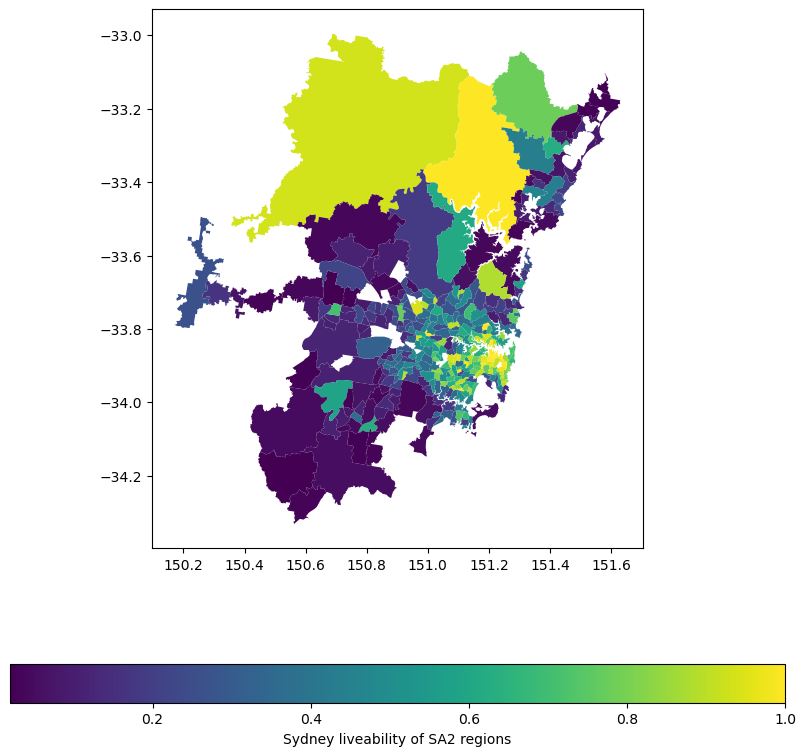

In [325]:
sydney = gpd.read_postgis("SELECT sa2code, sigmoid_value, geom FROM map_table", conn)
sydney.plot(column = 'sigmoid_value', figsize=(10, 10), legend=True, legend_kwds={"label": "Sydney liveability of SA2 regions", "orientation": "horizontal"})


**Summerisation of Results**

SA2 regions in the innercity have higher Sigmoid function values (closer to one; closer to yellow) indicating they are better resourced with the factors we used to caluculate this value: health facilities, retail venues, public transport, polling stations, school catchment.

**In Depth Analysis of Results**

Since we obtained the sigmoid value for each SA2 via:
 - the number of health facilities per 1000 people
 - the number of retail venues per 1000 people
 - the number of public transport stops per sqkm
 - the number of polling place per skqm
 - the number of school catchmement areas per 1000 young people

This map aligns with my knowledge of Sydney regions. (yay...)
The innercity, although densly populated, has very small SA2 areas and tends to be 'richer' areas, thus resources such as those listed are more accesable giving these areas a higher Sigmoid funciton value and more yellow colour on the map. Alternatively as Sydney spreads to the north east and west the area size of SA2 regions increase meaning there would be lower Z scores for polling places and stops per sqkm. Moreover these suburbs are not as well off so not as much governmenmt focus is placed on providing these regions with these facilities. (grrr...)

HOWEVER, there are some obvious outliers to this explanation, those high sigmoid scoring functions in Sydneys North West. This is because these regions are mostly bushland and national parks and therefore have much lower population, thus the number of health facilities, retail venues, and school catchment areas score much higher.

*for an even more in depth anaylsis of these fidnings, see report :)*

### My own Dataset

In [91]:
homeownership = pd.read_csv('homeownership.csv')

In [92]:
homeownership

,FID,the_geom,SA2_MAIN16,SA2_5DIG16,SA2_NAME16,SA3_CODE16,SA3_NAME16,SA4_CODE16,SA4_NAME16,GCC_CODE16,GCC_NAME16,STE_CODE16,STE_NAME16,AREASQKM16,Owners,PDs_Occu,S_I_17
0,Ownership_2016.1,"MULTIPOLYGON (((-35.4443 149.5842, -35.4438 14...",101021007,11007,Braidwood,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,3418.3525,1166.0,1439.0,81.03
1,Ownership_2016.2,"MULTIPOLYGON (((-35.3674 149.219, -35.3665 149...",101021008,11008,Karabar,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,6.9825,1997.0,2896.0,68.96
2,Ownership_2016.9,"MULTIPOLYGON (((-36.1352 148.6044, -36.1353 14...",101031015,11015,Cooma Region,10103,Snowy Mountains,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,6250.8748,1065.0,1254.0,84.93
3,Ownership_2016.10,"MULTIPOLYGON (((-36.4641 148.2703, -36.4637 14...",101031016,11016,Jindabyne - Berridale,10103,Snowy Mountains,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,3939.5484,1780.0,2871.0,62.00
4,Ownership_2016.11,"MULTIPOLYGON (((-35.7039 150.2354, -35.7038 15...",101041017,11017,Batemans Bay,10104,South Coast,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,63.7074,2011.0,3032.0,66.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2305,Ownership_2016.2304,NaN,899999499,89499,No usual address (ACT),89999,No usual address (ACT),899,No usual address (ACT),89499,No usual address (ACT),8,Australian Capital Territory,0.0000,NaN,NaN,NaN
2306,Ownership_2016.2305,"MULTIPOLYGON (((-10.4157 105.6739, -10.4155 10...",901011001,91001,Christmas Island,90101,Christmas Island,901,Other Territories,9OTER,Other Territories,9,Other Territories,136.1356,182.0,421.0,43.23
2307,Ownership_2016.2306,"MULTIPOLYGON (((-12.1764 96.8305, -12.1764 96....",901021002,91002,Cocos (Keeling) Islands,90102,Cocos (Keeling) Islands,901,Other Territories,9OTER,Other Territories,9,Other Territories,13.7163,39.0,127.0,30.71
2308,Ownership_2016.2307,"MULTIPOLYGON (((-35.183 150.6957, -35.1834 150...",901031003,91003,Jervis Bay,90103,Jervis Bay,901,Other Territories,9OTER,Other Territories,9,Other Territories,67.8134,7.0,81.0,8.64


Removing unessasary columns

In [93]:
homeownership = homeownership[['the_geom','SA2_MAIN16', 'SA2_NAME16','GCC_NAME16', 'Owners']]

Removing Duplicates

In [94]:
homeownership.drop_duplicates(inplace = True)

/var/folders/2w/069ckckj585c6q8nbb3881km0000gn/T/ipykernel_46196/2820304935.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  homeownership.drop_duplicates(inplace = True)


Checking for null values and remove

In [95]:
homeownership.isna().any()

the_geom       True
SA2_MAIN16    False
SA2_NAME16    False
GCC_NAME16    False
Owners         True
dtype: bool

In [96]:
homeownership = homeownership.dropna(subset=['the_geom'])
homeownership = homeownership.dropna(subset=['Owners'])

In [97]:
homeownership = homeownership.rename({'SA2_MAIN16' : 'sa2code', 'SA2_NAME16' : 'sa2name', 'GCC_NAME16' : 'greatercapital', 'the_geom' : 'geom', 'Owners': 'owners'}, axis =1)



In [98]:
conn.execute("""
DROP TABLE IF EXISTS homeownership;
CREATE TABLE homeownership (
     geom GEOMETRY(MULTIPOLYGON,4326),
     sa2code NUMERIC,
     sa2name VARCHAR(100),
     greatercapital VARCHAR(100),
     owners NUMERIC
);"""
)

In [99]:
homeownership.to_sql('homeownership', conn, if_exists='append', index=False, dtype={'geom': Geometry('POINT', srid)})
query(conn, "select * from homeownership")

,geom,sa2code,sa2name,greatercapital,owners
0,0106000020E6100000010000000103000000010000005F...,101021007.0,Braidwood,Rest of NSW,1166.0
1,0106000020E6100000010000000103000000010000002C...,101021008.0,Karabar,Rest of NSW,1997.0
2,0106000020E6100000010000000103000000020000006E...,101031015.0,Cooma Region,Rest of NSW,1065.0
3,0106000020E6100000010000000103000000010000005F...,101031016.0,Jindabyne - Berridale,Rest of NSW,1780.0
4,0106000020E61000000100000001030000000100000036...,101041017.0,Batemans Bay,Rest of NSW,2011.0
...,...,...,...,...,...
2287,0106000020E6100000010000000103000000010000000C...,801111141.0,Namadgi,Australian Capital Territory,3.0
2288,0106000020E61000000100000001030000000100000094...,901011001.0,Christmas Island,Other Territories,182.0
2289,0106000020E6100000380000000103000000010000000E...,901021002.0,Cocos (Keeling) Islands,Other Territories,39.0
2290,0106000020E61000000300000001030000000100000017...,901031003.0,Jervis Bay,Other Territories,7.0


In [100]:
sql = """
SELECT sa2code, sa2name, owners
FROM homeownership
WHERE greatercapital = 'Greater Sydney'
GROUP BY sa2code, sa2name, owners
ORDER BY sa2name
"""
query(conn, sql)

,sa2code,sa2name,owners
0,116021562.0,Acacia Gardens,910.0
1,119041375.0,Arncliffe - Bardwell Valley,3759.0
2,127011504.0,Ashcroft - Busby - Miller,2277.0
3,120031390.0,Ashfield,3953.0
4,121021403.0,Asquith - Mount Colah,4969.0
...,...,...,...
307,102011043.0,Wyoming,2975.0
308,102021057.0,Wyong,1871.0
309,119011361.0,Yagoona - Birrong,3765.0
310,124041468.0,Yarramundi - Londonderry,1351.0


I find my Z score by finding the number of homeowners per 1000 people in each area.

In [101]:
sql = """
SELECT *
FROM population 
ORDER BY sa2_name
"""
query(conn, sql)

,sa2_code,sa2_name,total_people
0,116021562.0,Acacia Gardens,3681.0
1,120021674.0,Annandale (NSW),9516.0
2,119041668.0,Arncliffe - Bardwell Valley,16651.0
3,121011682.0,Artarmon,9469.0
4,127011504.0,Ashcroft - Busby - Miller,18088.0
...,...,...,...
368,102021057.0,Wyong,9193.0
369,119011361.0,Yagoona - Birrong,22580.0
370,124041468.0,Yarramundi - Londonderry,7564.0
371,125031487.0,Yennora Industrial,13.0


In [102]:
sql = """
SELECT h.sa2code, h.sa2name, h.owners, p.total_people, (owners/total_people)*1000 as owners_per_thousand
FROM population p JOIN homeownership h ON (p.sa2_code = h.sa2code)
WHERE h.greatercapital = 'Greater Sydney'
GROUP BY h.sa2code, h.sa2name, h.owners, p.total_people
HAVING p.total_people >=100
ORDER BY h.sa2name
"""
query(conn, sql)

,sa2code,sa2name,owners,total_people,owners_per_thousand
0,116021562.0,Acacia Gardens,910.0,3681.0,247.215431
1,127011504.0,Ashcroft - Busby - Miller,2277.0,18088.0,125.884564
2,121021403.0,Asquith - Mount Colah,4969.0,22134.0,224.496250
3,125011582.0,Auburn - Central,2204.0,19663.0,112.088695
4,125011583.0,Auburn - North,1107.0,10708.0,103.380650
...,...,...,...,...,...
242,102011042.0,Woy Woy - Blackwall,3649.0,14402.0,253.367588
243,102011043.0,Wyoming,2975.0,11457.0,259.666579
244,102021057.0,Wyong,1871.0,9193.0,203.524421
245,119011361.0,Yagoona - Birrong,3765.0,22580.0,166.740478


In [103]:
homeowners = pd.read_sql_query(sql, conn)

In [104]:
mean = np.mean(homeowners['owners_per_thousand'])
std = np.std(homeowners['owners_per_thousand']) 
print(mean)
print(std)

210.87173922878728
48.94361114814485


In [237]:
sql = """
SELECT h.sa2code, h.sa2name, h.owners, p.total_people, (owners/total_people)*1000 as owners_per_thousand, ((owners/total_people)*1000 - 210.87)/48.94 as Zscore
FROM population p JOIN homeownership h ON (p.sa2_code = h.sa2code)
WHERE h.greatercapital = 'Greater Sydney'
GROUP BY h.sa2code, h.sa2name, h.owners, p.total_people
HAVING p.total_people >=100
ORDER BY h.sa2name
"""
query(conn, sql)

,sa2code,sa2name,owners,total_people,owners_per_thousand,zscore
0,116021562.0,Acacia Gardens,910.0,3681.0,247.215431,0.742653
1,127011504.0,Ashcroft - Busby - Miller,2277.0,18088.0,125.884564,-1.736523
2,121021403.0,Asquith - Mount Colah,4969.0,22134.0,224.496250,0.278428
3,125011582.0,Auburn - Central,2204.0,19663.0,112.088695,-2.018417
4,125011583.0,Auburn - North,1107.0,10708.0,103.380650,-2.196350
...,...,...,...,...,...,...
242,102011042.0,Woy Woy - Blackwall,3649.0,14402.0,253.367588,0.868361
243,102011043.0,Wyoming,2975.0,11457.0,259.666579,0.997069
244,102021057.0,Wyong,1871.0,9193.0,203.524421,-0.150094
245,119011361.0,Yagoona - Birrong,3765.0,22580.0,166.740478,-0.901707


In [238]:
homeowners_z = pd.read_sql_query(sql, conn)
homeowners_z = homeowners_z[['sa2code','zscore']]

conn.execute("""
DROP TABLE IF EXISTS homeowners_z;
CREATE TABLE homeowners_z (
    sa2code NUMERIC, 
    zscore NUMERIC
);"""
)

homeowners_z.to_sql('homeowners_z', conn, if_exists='append', index=False, dtype={'geom': Geometry('POINT', srid)})
query(conn, "select * from homeowners_z")

,sa2code,zscore
0,116021562.0,0.742653
1,127011504.0,-1.736523
2,121021403.0,0.278428
3,125011582.0,-2.018417
4,125011583.0,-2.196350
...,...,...
242,102011042.0,0.868361
243,102011043.0,0.997069
244,102021057.0,-0.150094
245,119011361.0,-0.901707


In [106]:
#correlation matrix and visualisation
#create 2 or three indexes
# create inde

# Own datset SID: 520617829.
Kindly note that the data was imported in Postgresql in a different method to what is used in the tutorial and is viewable in Pgadmin4 under "myschema". Also note that the type of theis file is .json as required to be by the specification.

In [1]:
srid = 4326
import psycopg2
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon
from geoalchemy2 import Geometry, WKTElement
from sqlalchemy import create_engine

# PostgreSQL connection details
host = "localhost"
port = 5432
database = "postgres"
user = "postgres"
password = "839096"

# Create SQLAlchemy engine
engine = create_engine(f"postgresql+psycopg2://{user}:{password}@{host}:{port}/{database}")

# Function to create a new schema if it doesn't exist
def create_schema_if_not_exists(engine, schema_name):
    with engine.connect() as connection:
        result = connection.execute(f"SELECT schema_name FROM information_schema.schemata WHERE schema_name = '{schema_name}';")
        if not result.fetchone():
            connection.execute(f"CREATE SCHEMA {schema_name};")

# Create a new schema
schema_name = 'myschema'
create_schema_if_not_exists(engine, schema_name)

import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon
from geoalchemy2 import Geometry, WKTElement
from psycopg2.extensions import AsIs
import matplotlib.pyplot as plt

# Read the GeoJSON file
gdf = gpd.read_file("datasource-UNSW_CFRC-UNSW_CFRC_GEONODE_geonode_RentalHouseholds_2016.json")

gdf = gdf.drop(columns=['id', 'SA3_CODE16',"SA3_NAME16","SA4_CODE16","SA4_NAME16","GCC_CODE16","GCC_NAME16"])
gdf = gdf.drop(columns=['STE_CODE16', 'STE_NAME16',"AREASQKM16","PDs_Occu","S_I_18"])

gdf = gdf.dropna(subset=['geometry'])

def create_wkt_element(geom1, srid):
    if geom1.geom_type == 'Polygon':
        geom1 = MultiPolygon([geom1])
    return WKTElement(geom1.wkt, srid)
gdf['geom'] = gdf['geometry'].apply(lambda x: create_wkt_element(geom1=x,srid=srid))  # applying the function

gdf = gdf.drop(columns=["geometry"])

import numpy as np

# 1. Calculate the mean and standard deviation of the "Renters" column
renters_mean = gdf['Renters'].mean()
renters_std = gdf['Renters'].std()

# 2. Calculate the z-score for each value in the "Renters" column
gdf['Renters_zscore'] = (gdf['Renters'] - renters_mean) / renters_std

# Print the updated GeoDataFrame with the z-score column
print(gdf)

table_name = 'rent'
schema_name = 'myschema'

# Specify the geometry column data type   
dtype = {'geom': Geometry('MULTIPOLYGON', srid)}

# Upload the GeoDataFrame to the SQL table
gdf.to_sql(name=table_name, 
           con=engine,  
           schema=schema_name,  
           if_exists='replace',  
           index=False, 
           method='multi',  
           dtype=dtype)

     SA2_MAIN16 SA2_5DIG16               SA2_NAME16  Renters  \
0     101021007      11007                Braidwood    272.0   
1     101021008      11008                  Karabar    897.0   
2     101031015      11015             Cooma Region    173.0   
3     101031016      11016    Jindabyne - Berridale   1024.0   
4     101041017      11017             Batemans Bay    986.0   
...         ...        ...                      ...      ...   
2303  801111141      81141                  Namadgi     13.0   
2306  901011001      91001         Christmas Island    240.0   
2307  901021002      91002  Cocos (Keeling) Islands     76.0   
2308  901031003      91003               Jervis Bay     68.0   
2309  901041004      91004           Norfolk Island    231.0   

                                                   geom  Renters_zscore  
0     MULTIPOLYGON (((149.5842 -35.4443, 149.5844 -3...       -0.821901  
1     MULTIPOLYGON (((149.219 -35.3674, 149.218 -35....       -0.228229  
2     MUL

2292

Final Score of different metrics and kindly note that this was done in a different way as opposed to the rest of the jupyter workflow and maybe required to run in a different notebook with the connection code. It was decided that the method mentioned in the tutorial is a more efficient way to submit the overall code. This table('combined_zscores'in the below cell) can viewed with all the other tables under myschema:

In [5]:

schema_name = 'myschema'
create_schema_if_not_exists(engine, schema_name)
import pandas as pd;
df = pd.read_csv("data2001zscores.csv")
new_taby_name = 'zscores'
df.to_sql(name=new_taby_name, con=engine, schema=schema_name, if_exists='replace', index=False, method='multi')

def query(conn, sql):
    return pd.read_sql_query(sql, conn)

# Perform an inner join on the SA2_MAIN16 column to get the rows that exist in both datasets, and select the desired columns,
# including the Renters_zscore column from the first dataset
querys = '''
WITH score_table AS (
    SELECT
        t2."sa2code",
        t2."retailz",
        t2."healthz",
        t2."stopsz",
        t2."pollsz",
        t2."schoolsz",
        1.0 / (1.0 + EXP(-1.0 * (t2."retailz" + t2."healthz" + t2."stopsz" + t2."pollsz" + t2."schoolsz"))) AS "Score"
    FROM
        myschema.zscores AS t2
    
)
SELECT *
FROM score_table
'''

result_df = query(engine, querys)

# Display the results
print(result_df)

# Save the result to a new table
result_table_name = 'combined_zscores'
result_df.to_sql(name=result_table_name, con=engine, schema=schema_name, if_exists='replace', index=False, method='multi')

csv_filename = 'Score_res.csv'  # Choose a filename for your CSV file
result_df.to_csv(csv_filename, index=False)

         sa2code   retailz   healthz    stopsz    pollsz  schoolsz     Score
0    123031446.0 -0.463388 -0.496465 -1.696173 -0.524318  0.267050  0.051500
1    123021436.0 -0.670284 -0.676365 -1.189644 -0.459787 -0.455671  0.030717
2    125011584.0  0.028477 -0.275095  0.577046  0.117887  0.463771  0.713427
3    102011035.0 -0.770539 -0.582616 -0.817391 -0.463246 -0.186926  0.056215
4    102021044.0 -0.575753 -0.597131  0.161807 -0.240775 -0.840137  0.109878
..           ...       ...       ...       ...       ...       ...       ...
347  119011657.0 -0.603623 -0.538789 -0.541781 -0.253278 -0.067976  0.118632
348  118011650.0  1.171862  2.663770  1.477807  0.481327  0.634140  0.998388
349  127011597.0 -0.458312 -0.444064 -1.073212 -0.304293 -0.725271  0.047194
350  128011529.0 -0.431855 -0.188627  0.333132 -0.077664 -0.665952  0.262897
351  116031314.0 -0.291880 -0.583859 -0.429047 -0.326899  0.453082  0.235304

[352 rows x 7 columns]


Kindly note that the all of the datasets were imported to Postgresql via the engine as shown in the cell above for SID:520617829 because they found it more easy to understand and execute as compared to the tutorial method the scrrenshot of hpw they were imported is attached below along with a code snippet in the following cell as an example of its functionality. All datasets are viewable under myschema in pgadmin. 
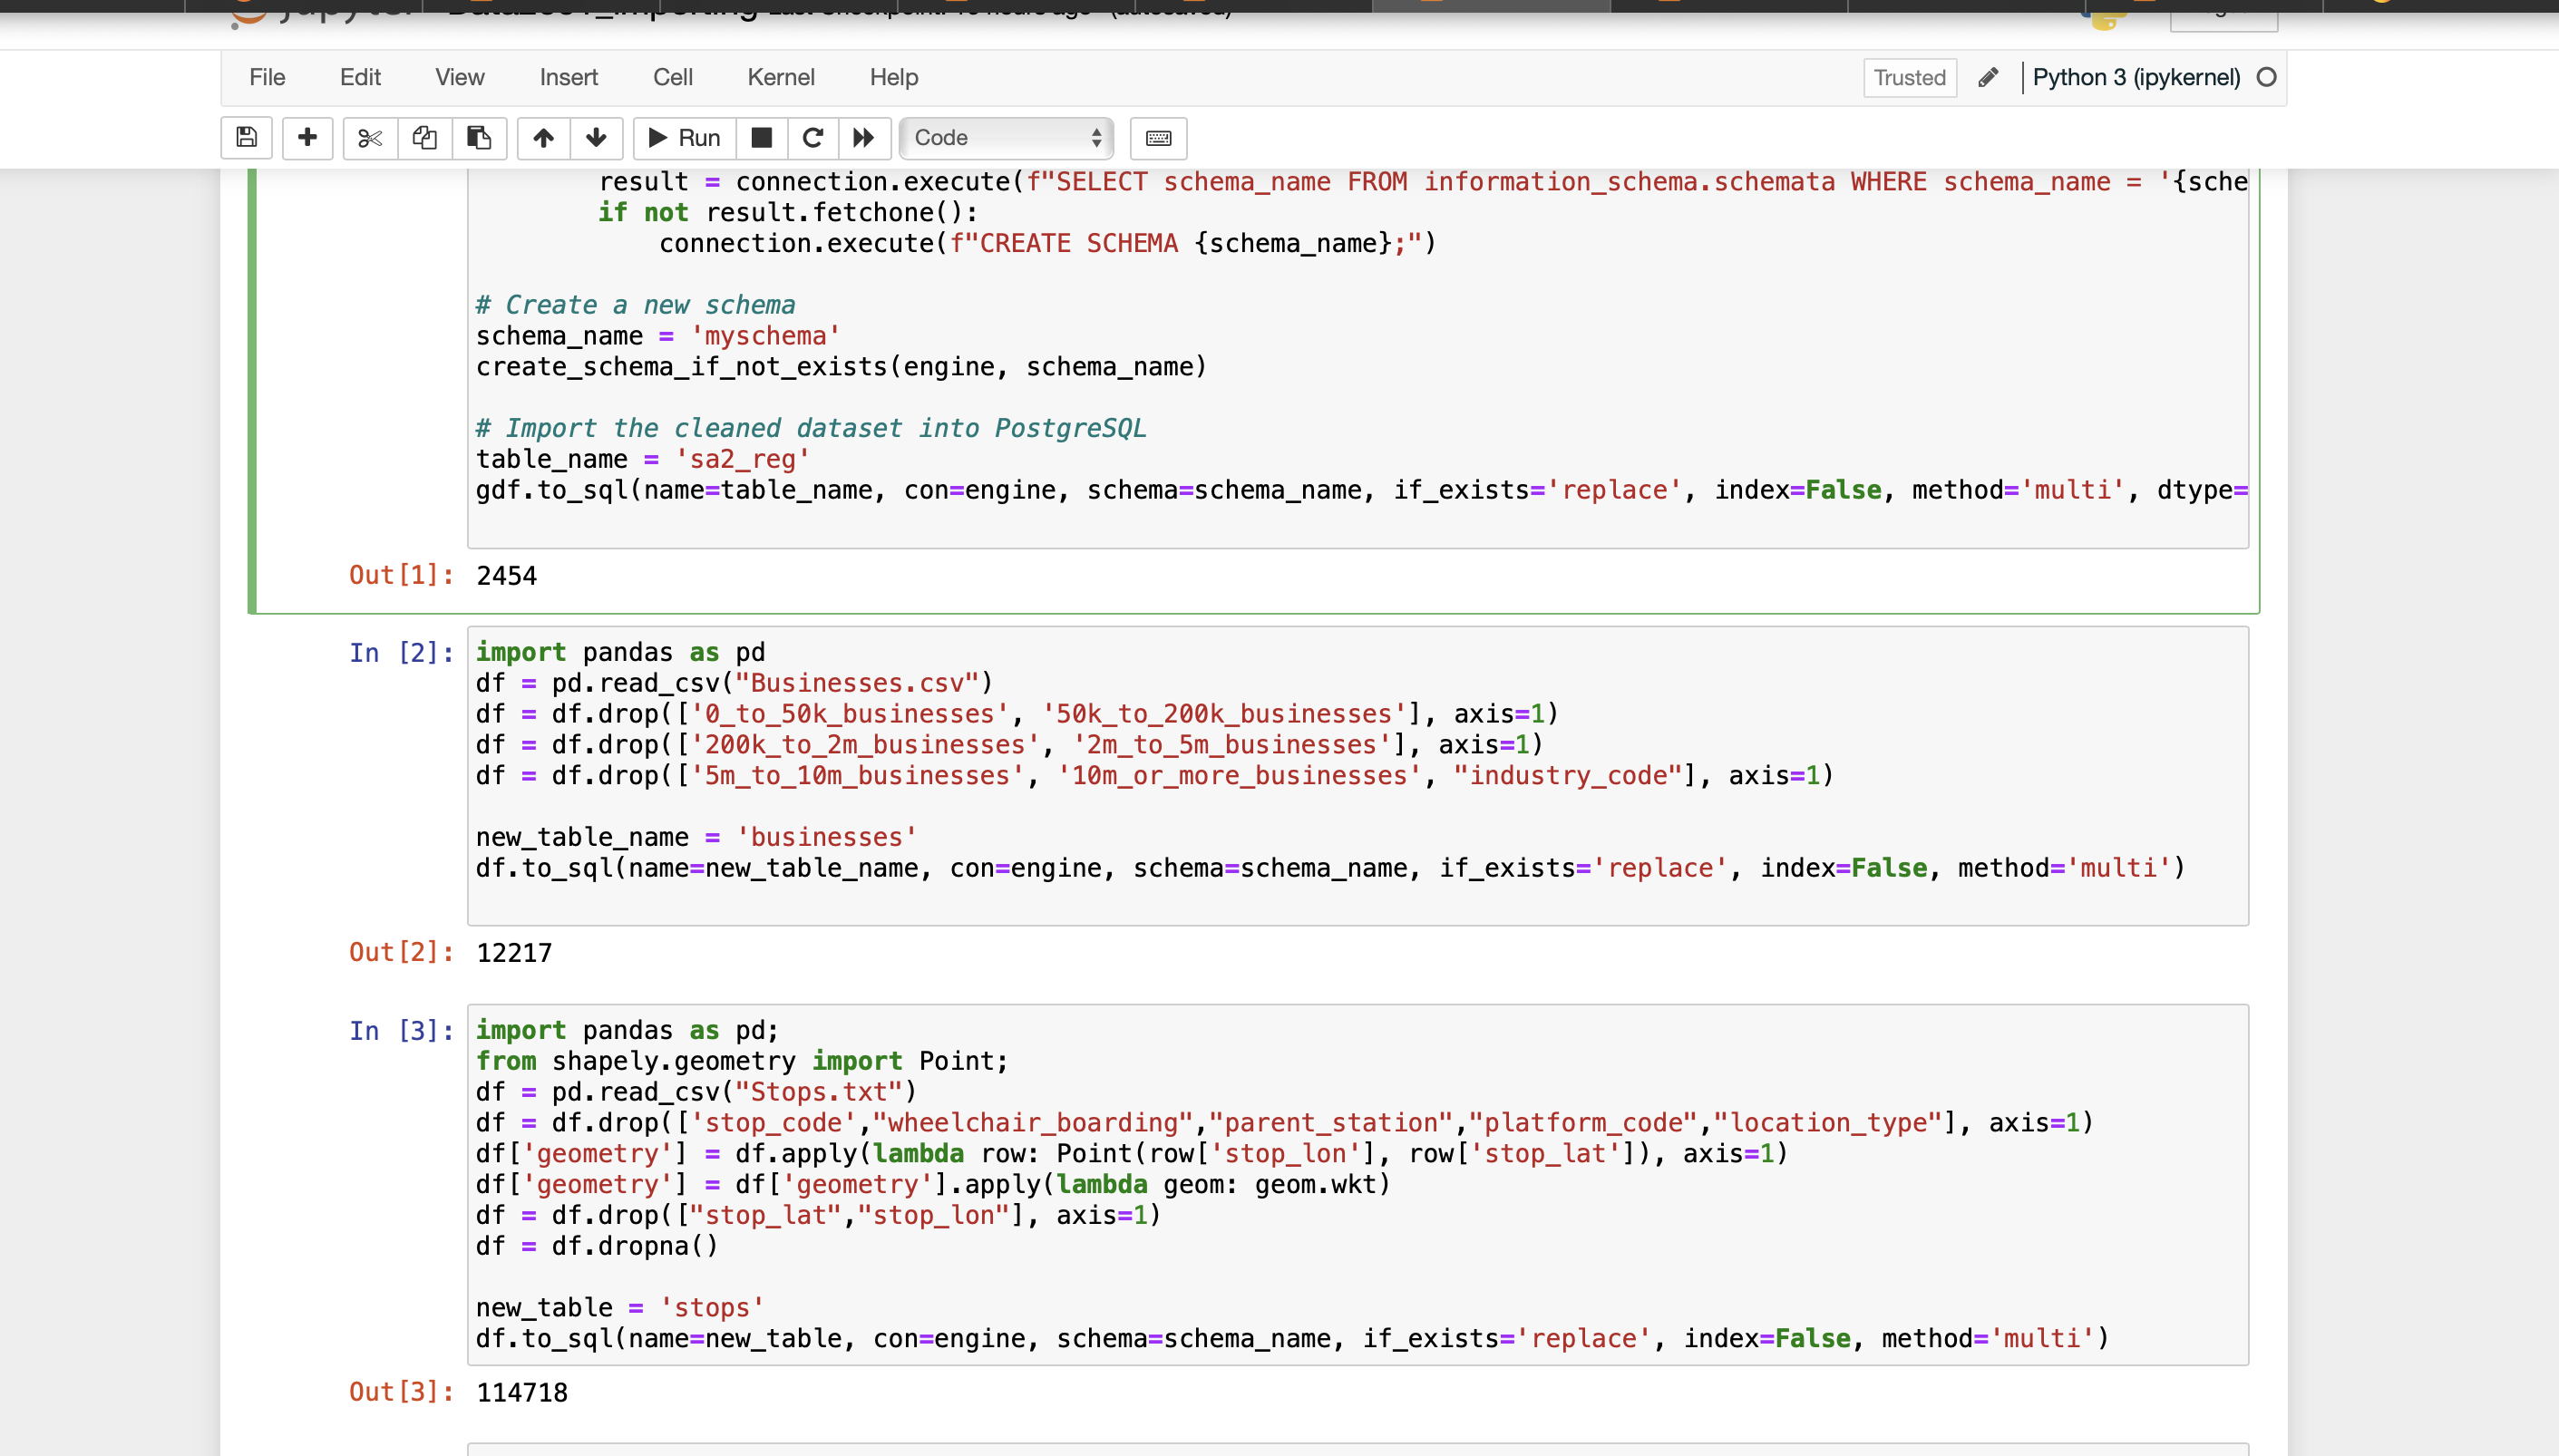
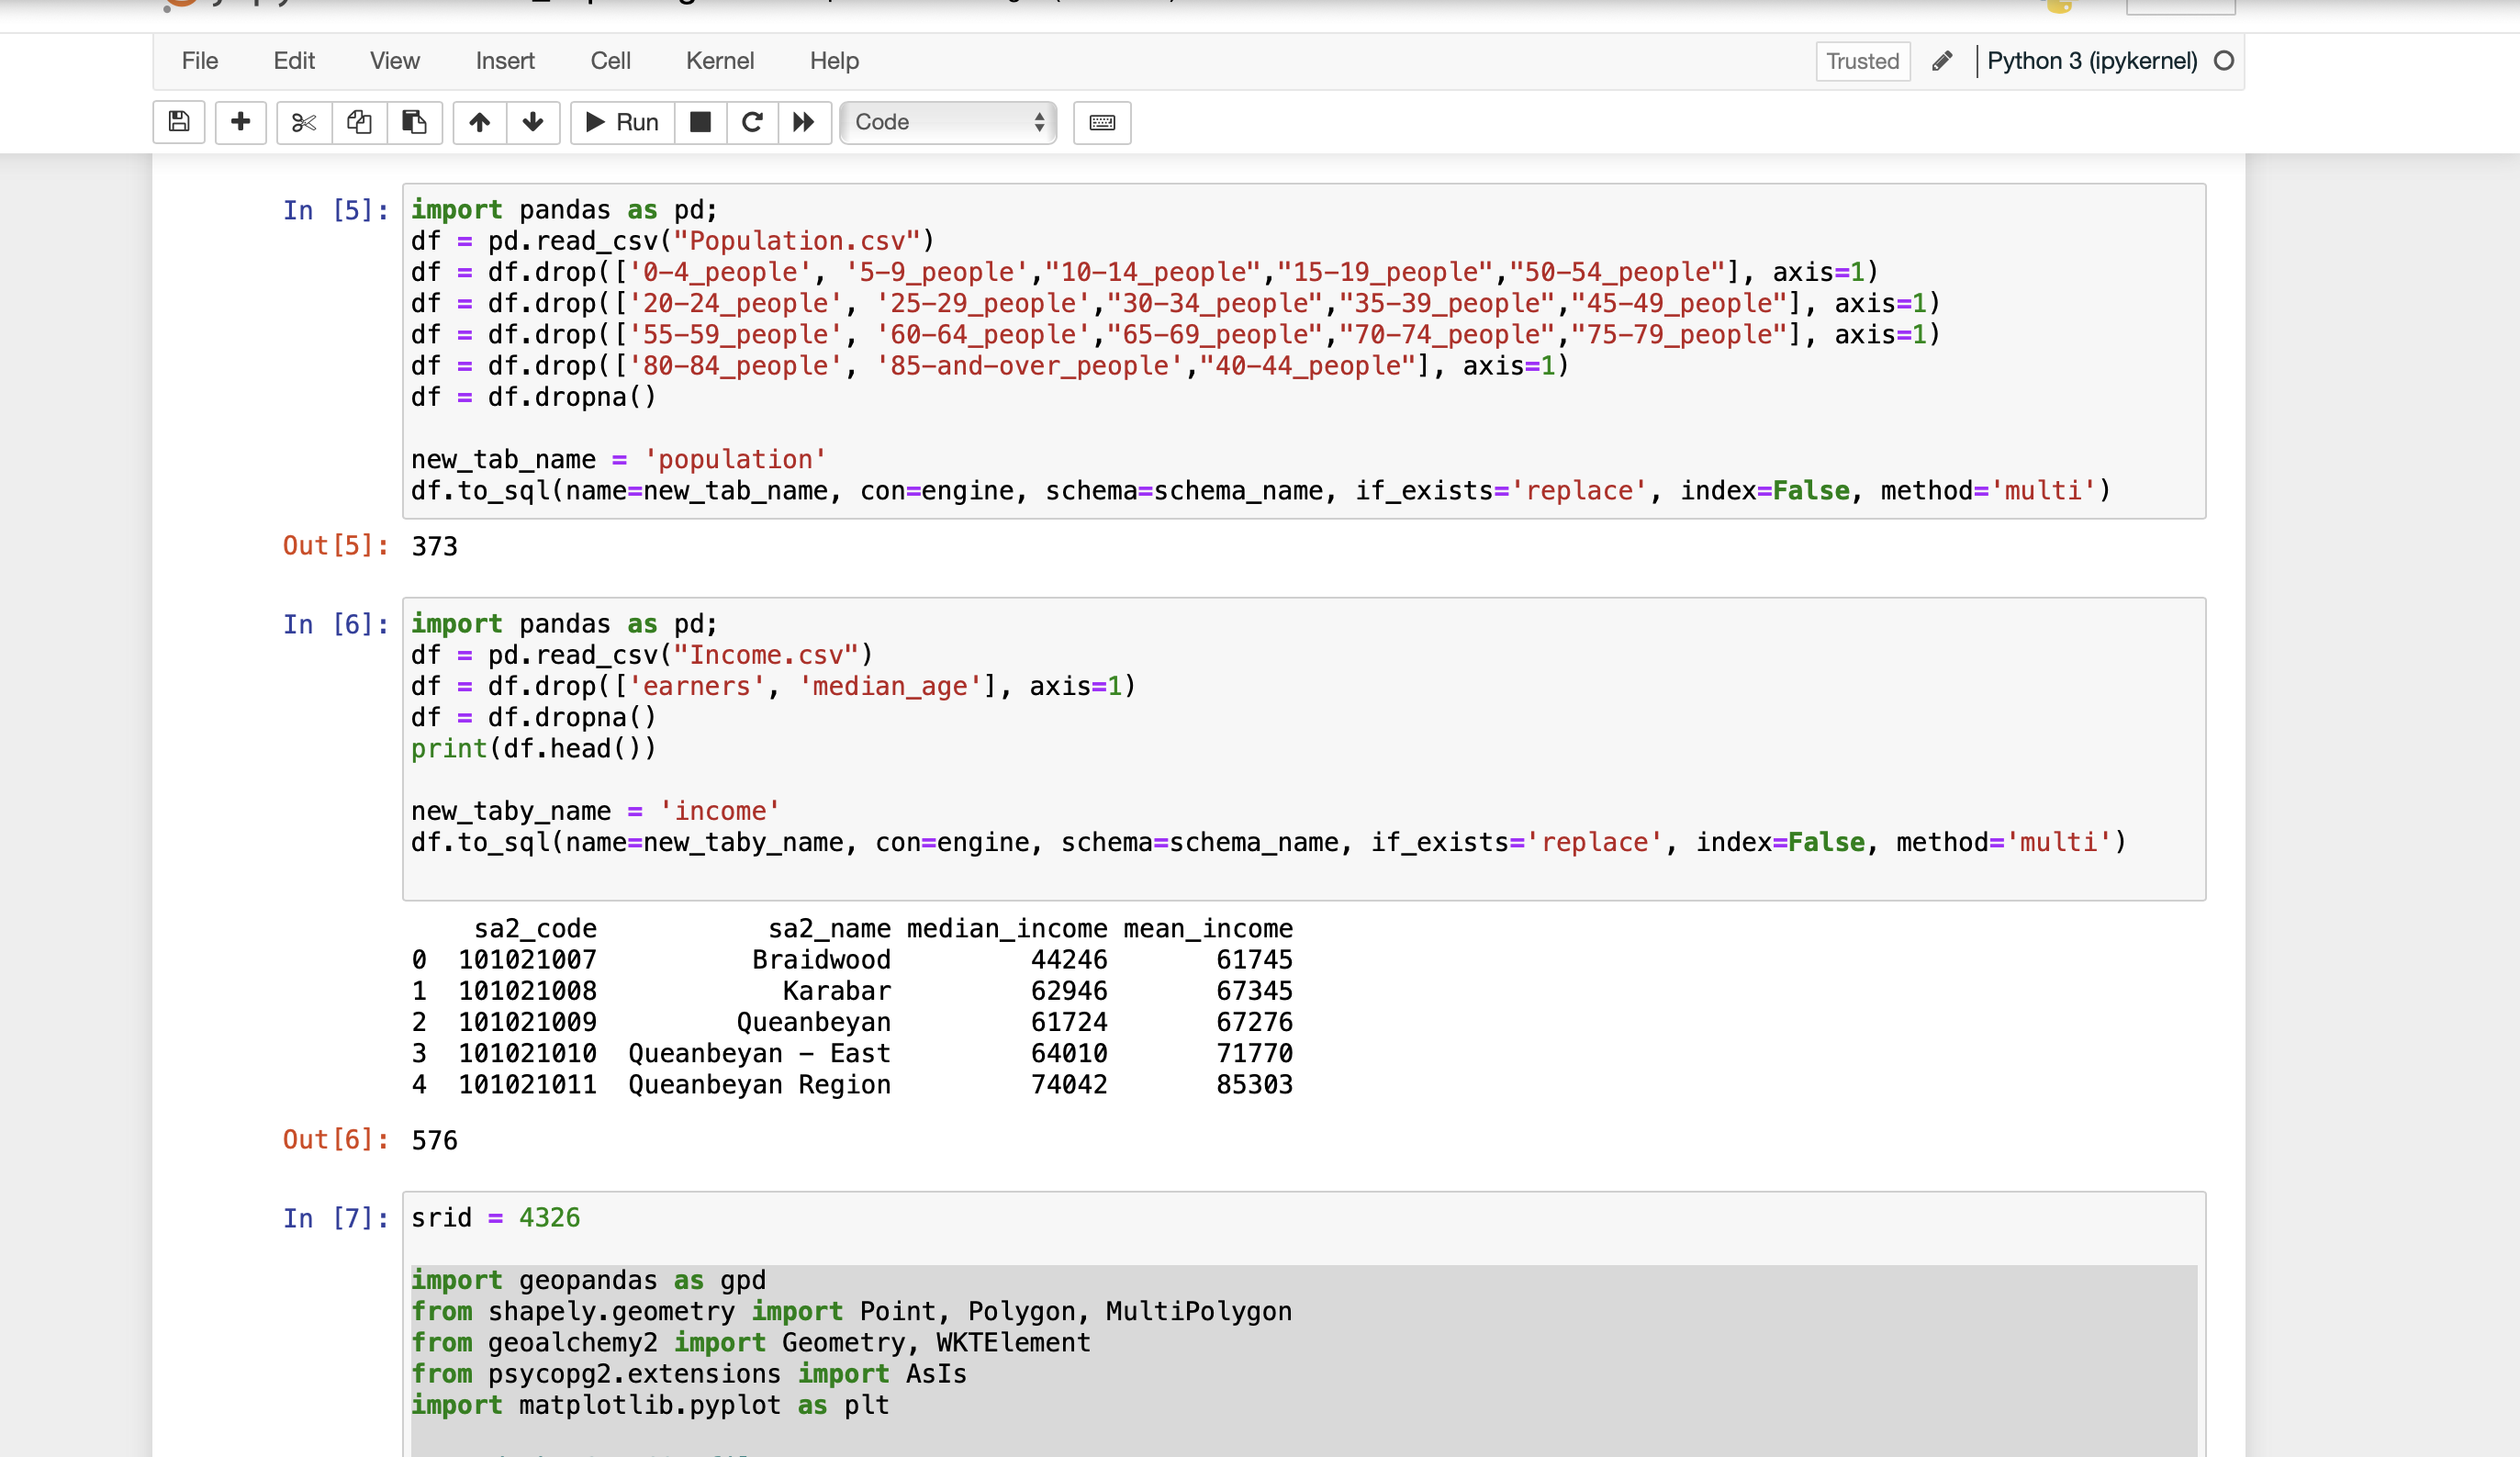

In [4]:
#Example of functionality cleaning and importing catchments as schools in pgadmin the engine is the same as the above cells
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon
from geoalchemy2 import Geometry, WKTElement
import matplotlib.pyplot as plt
srid = 4326
shapefile_path1 = "catchments_primary.shp"
shapefile_path2 = "catchments_secondary.shp"
shapefile_path3 = "catchments_future.shp"
gdf1 = gpd.read_file(shapefile_path1)
gdf1 = gdf1.drop(columns=['CATCH_TYPE', 'ADD_DATE',"KINDERGART","YEAR1","YEAR2","YEAR3","YEAR4"])
gdf1 = gdf1.drop(columns=['YEAR5', 'YEAR6',"YEAR7","YEAR8","YEAR9","YEAR10","YEAR11","YEAR12","PRIORITY"])
def create_wkt_element(geom1, srid):
    if geom1.geom_type == 'Polygon':
        geom1 = MultiPolygon([geom1])
    return WKTElement(geom1.wkt, srid)
gdf1['geom1'] = gdf1['geometry'].apply(lambda x: create_wkt_element(geom1=x,srid=srid))  # applying the function
gdf1 = gdf1.drop(columns="geometry")  # deleting the old copy
gdf1 = gdf1.dropna()

gdf2 = gpd.read_file(shapefile_path2)
gdf2 = gdf2.drop(columns=['CATCH_TYPE', 'ADD_DATE',"KINDERGART","YEAR1","YEAR2","YEAR3","YEAR4"])
gdf2 = gdf2.drop(columns=['YEAR5', 'YEAR6',"YEAR7","YEAR8","YEAR9","YEAR10","YEAR11","YEAR12","PRIORITY"])
def create_wkt_element(geom2, srid):
    if geom2.geom_type == 'Polygon':
        geom2 = MultiPolygon([geom2])
    return WKTElement(geom2.wkt, srid)
gdf2['geom'] = gdf2['geometry'].apply(lambda x: create_wkt_element(geom2=x,srid=srid))  # applying the function
gdf2 = gdf2.drop(columns="geometry")  # deleting the old copy
gdf2 = gdf2.dropna()

gdf3 = gpd.read_file(shapefile_path3)

gdf3 = gdf3.drop(columns="geometry")  
gdf3 = gdf3.dropna()

gdf = gpd.GeoDataFrame(pd.concat([gdf1, gdf2, gdf3], ignore_index=True))

columns_to_remove = [
    "geom", "CATCH_TYPE", "ADD_DATE", "KINDERGART", "YEAR1", "YEAR2", "YEAR3", "YEAR4", "YEAR5",
    "YEAR6", "YEAR7", "YEAR8", "YEAR9", "YEAR10", "YEAR11", "YEAR12"
]

gdf = gdf.drop(columns=columns_to_remove)

print(gdf.head())


  USE_ID         USE_DESC                                              geom1
0   2838       Parklea PS  MULTIPOLYGON (((150.93563850416004 -33.7161211...
1   2404    Lindfield EPS  MULTIPOLYGON (((151.1833640465581 -33.74748398...
2   4393  Carlingford WPS  MULTIPOLYGON (((151.0451821055135 -33.77303212...
3   4615   Caddies Ck  PS  MULTIPOLYGON (((150.92567327976582 -33.7296030...
4   3918       Killara PS  MULTIPOLYGON (((151.1537883781186 -33.75586174...


# IN DEPTH ANALYSIS OF CORRELATION

The following is the correlation between median income of each SA2 region and Score of different metrics, some key point to be noted:
1) The overall score was calculated without the individual datasets i.e. only the given datasets and their metrics were considered.
2) The points in the scatterplot are spread out and the plot seemns to have many outliers.
3) The median income is far greater in value as compared to the Scores which is why that data had to be rescaled between 0 and 1.
4) The line of best fit was added to give a more clear idea of correlation and it is positive but as mentioned before has many outliers.
5) The Scores though seem to be a fairly accurate measure of the quality of life and hence the income increases with an increase in Score.
For more detailed explanation please refer to the report.

    sa2_code median_income
0  101021007         44246
1  101021008         62946
2  101021009         61724
3  101021010         64010
4  101021011         74042
     sa2code     Score
0  123031446  0.051500
1  123021436  0.030717
2  125011584  0.713427
3  102011035  0.056215
4  102021044  0.109878
      sa2_code median_income     Score
0    102011028         52450  0.225917
1    102011029         48724  0.046733
2    102011030         46228  0.996836
3    102011031         48292  0.434973
4    102011032         51999  0.467230
..         ...           ...       ...
239  128021536         64428  0.181381
240  128021538         62453  0.308240
241  128021607         60914  0.143743
242  128021608         60469  0.371812
243  128021609         63811  0.338285

[244 rows x 3 columns]


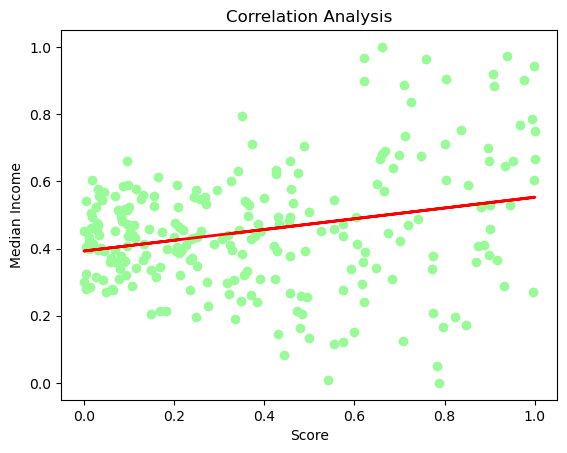

In [6]:
import pandas as pd;
df1 = pd.read_csv("Income.csv")
df1 = df1.drop(columns=['sa2_name', 'earners',"median_age","mean_income"])
print(df1.head())
import pandas as pd;
df = pd.read_csv("Score_res.csv")
df = df.drop(columns=['retailz', 'healthz',"stopsz","pollsz","schoolsz"])
# Changing the data type of the 'sa2code' column to int
df['sa2code'] = df['sa2code'].astype(int)
print(df.head())
# Combining the two DataFrames based on matching values in 'sa2code' and 'sa2_code'
result = df1.merge(df, left_on='sa2_code', right_on='sa2code')
result = result.drop(columns=["sa2code"])
print(result)
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

x_column = "Score"
y_column = "median_income"

# Convert the columns to numeric data type
result[x_column] = pd.to_numeric(result[x_column], errors='coerce')
result[y_column] = pd.to_numeric(result[y_column], errors='coerce')

# Remove any rows with NaN values
result = result.dropna(subset=[x_column, y_column])

# Apply Min-Max scaling to the data
result[x_column] = (result[x_column] - result[x_column].min()) / (result[x_column].max() - result[x_column].min())
result[y_column] = (result[y_column] - result[y_column].min()) / (result[y_column].max() - result[y_column].min())

# Fit a linear regression model
X = result[x_column].values.reshape(-1, 1)
y = result[y_column].values.reshape(-1, 1)
reg = LinearRegression().fit(X, y)
y_pred = reg.predict(X)

# Plot the scatter plot
plt.scatter(result[x_column], result[y_column], color='#98fb98')
plt.plot(result[x_column], y_pred, color='red', linewidth=2)  # Add the line of best fit
plt.xlabel("Score")
plt.ylabel("Median Income")
plt.title('Correlation Analysis')
plt.show()